In [61]:
import torch

import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import f1_score, roc_auc_score

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [62]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [63]:
args = {'batch_size': 128,
    'lr': 3e-3,
    'hidden_dim': 128,
    'n_layers': 3,
    'bidirectional': True,
    'dropout': 0.25,
    'n_epochs': 50,
    'b1': 0.9,
    'b2': 0.999,
    'weight_decay': 0.1 
}

In [64]:
print(torch.cuda.is_available())

True


In [65]:
df = pd.read_csv("../data/training_data/data1.csv", sep=",")

for i in range(2, 11):
    if i != 3:
        filename = "../data/training_data/data" + str(i) + ".csv"
        df = df.append(pd.read_csv(filename, sep=","))
import math

df = df.sample(frac=1)

train_num = math.ceil(0.7 * len(df))
valid_num = math.ceil(0.9 * len(df))
train_data = df.iloc[:train_num, :]
valid_data = df.iloc[train_num:valid_num, :].reset_index()
test_data = df.iloc[valid_num:, :].reset_index()

In [66]:
num_positive = (df["sentiment"] == "positive").sum()
num_negative = (df["sentiment"] == "negative").sum()
num_neutral = (df["sentiment"] == "neutral").sum()

args["weight"] = torch.tensor([num_negative / len(df), num_neutral / len(df), num_positive / len(df)], dtype=torch.float32)

print(args["weight"])

tensor([0.1568, 0.4639, 0.3793])


In [67]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [68]:
tokenized_train = train_data['text'].apply((
    lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_valid = valid_data['text'].apply((
    lambda x: tokenizer.encode(x, add_special_tokens=True)))
tokenized_test = test_data['text'].apply((
    lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [69]:
# max_len = tokenizer.max_model_input_sizes['distilbert-base-uncased']

# print(max_len)

In [70]:
def get_max_len(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    return max_len

In [71]:
max_len_train = get_max_len(tokenized_train)
print(max_len_train)
max_len_valid = get_max_len(tokenized_valid)
print(max_len_valid)
max_len_test = get_max_len(tokenized_test)
print(max_len_test)
max_len = max([max_len_train, max_len_valid, max_len_test])

59
112
58


In [72]:
padded_train = torch.tensor([i + [0] * (max_len - len(i)) 
                             for i in tokenized_train.values])
padded_valid = torch.tensor([i + [0] * (max_len - len(i)) 
                             for i in tokenized_valid.values])
padded_test = torch.tensor([i + [0] * (max_len - len(i)) 
                            for i in tokenized_test.values])

In [73]:
train_label = torch.tensor(train_data['sentiment'].replace(
    to_replace='positive', value=2).replace(
    to_replace='negative', value=0).replace(
    to_replace='neutral', value=1).to_numpy())
valid_label = torch.tensor(valid_data['sentiment'].replace(
    to_replace='positive', value=2).replace(
    to_replace='negative', value=0).replace(
    to_replace='neutral', value=1).to_numpy())
test_label = torch.tensor(test_data['sentiment'].replace(
    to_replace='positive', value=2).replace(
    to_replace='negative', value=0).replace(
    to_replace='neutral', value=1).to_numpy())

In [74]:
# Define the dataset and data iterators
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, x, labels):
        'Initialization'
        self.x = x
        self.labels = labels

    def __len__(self):
        'Denotes the total number of samples'
        return self.x.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        x = self.x[index]
        y = self.labels[index]

        return x, y

In [75]:
trainset = Dataset(padded_train, train_label)
validset = Dataset(padded_valid, valid_label)
testset = Dataset(padded_test, test_label)

train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size=args['batch_size'],
                                           shuffle=True,
                                           drop_last=True)
valid_loader = torch.utils.data.DataLoader(validset,
                                           batch_size=args['batch_size'],
                                           shuffle=True,
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(testset,
                                           batch_size=args['batch_size'],
                                           shuffle=True,
                                           drop_last=True)

In [76]:
torch.save(train_loader, "train_loader.pth")
torch.save(valid_loader, "valid_loader.pth")
torch.save(test_loader, "test_loader.pth")

In [33]:
bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [34]:
class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['dim']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
        attention_mask = text.masked_fill(text != 0, 1)
                
        with torch.no_grad():
            embedded = self.bert(text, attention_mask=attention_mask)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output

In [35]:
model = BERTGRUSentiment(bert,
                         args['hidden_dim'],
                         3,
                         args['n_layers'],
                         args['bidirectional'],
                         args['dropout'])

In [36]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,283,331 trainable parameters


In [38]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

rnn.weight_ih_l0
rnn.weight_hh_l0
rnn.bias_ih_l0
rnn.bias_hh_l0
rnn.weight_ih_l0_reverse
rnn.weight_hh_l0_reverse
rnn.bias_ih_l0_reverse
rnn.bias_hh_l0_reverse
rnn.weight_ih_l1
rnn.weight_hh_l1
rnn.bias_ih_l1
rnn.bias_hh_l1
rnn.weight_ih_l1_reverse
rnn.weight_hh_l1_reverse
rnn.bias_ih_l1_reverse
rnn.bias_hh_l1_reverse
rnn.weight_ih_l2
rnn.weight_hh_l2
rnn.bias_ih_l2
rnn.bias_hh_l2
rnn.weight_ih_l2_reverse
rnn.weight_hh_l2_reverse
rnn.bias_ih_l2_reverse
rnn.bias_hh_l2_reverse
out.weight
out.bias


In [47]:
optimizer = optim.Adam(model.parameters(), 
                       lr=args['lr'], 
                       betas=(args["b1"], args["b2"]),
                       weight_decay=args["weight_decay"])
criterion = nn.CrossEntropyLoss(weight=args['weight'])
model = model.to(device)
criterion = criterion.to(device)

In [49]:
def multi_acc(y_pred, y_label):
    softmax = nn.Softmax(dim=1)
    y_pred_softmax = softmax(y_pred)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)

    # accu
    correct_pred = (y_pred_tags == y_label).float()
    acc = correct_pred.sum() / len(y_label)

    # roc-auc
    one_hot_label = nn.functional.one_hot(y_label)
    roc_auc = roc_auc_score(one_hot_label.detach().cpu(), y_pred_softmax.detach().cpu(), average="macro")

    # f1
    f1 = f1_score(y_label.detach().cpu(), y_pred_tags.detach().cpu(), average='weighted')
    
    return acc, roc_auc, f1

In [50]:
def train(model, data_loader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_rocauc = 0
    epoch_f1 = 0
    
    model.train()
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        
        predictions = model(data).squeeze(1)
        
        loss = criterion(predictions, target)
        
        acc, roc_auc, f1 = multi_acc(predictions, target)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_rocauc += roc_auc
        epoch_f1 += f1

        print("batch idx {}: | train loss: {} | train accu: {:.3f} | train roc: {:.3f} | train f1: {}".format(
            batch_idx, loss.item(), acc.item(), roc_auc, f1))
        
    return epoch_loss / len(data_loader), epoch_acc / len(data_loader), epoch_rocauc / len(data_loader), epoch_f1 / len(data_loader)

In [51]:
def evaluate(model, data_loader, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_rocauc = 0
    epoch_f1 = 0
    model.eval()
    
    with torch.no_grad():
    
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            
            predictions = model(data).squeeze(1)
            
            loss = criterion(predictions, target)
            
            acc, roc_auc, f1 = multi_acc(predictions, target)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_rocauc += roc_auc
            epoch_f1 += f1
        
    return epoch_loss / len(data_loader), epoch_acc / len(data_loader), epoch_rocauc / len(data_loader), epoch_f1 / len(data_loader)

In [52]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [53]:
history = {
    "train_loss": [],
    "valid_loss": []
}

best_valid_loss = float('inf')

for epoch in range(args['n_epochs']):
    
    start_time = time.time()
    
    train_loss, train_acc, train_rocauc, train_f1 = train(model, train_loader, optimizer, criterion)
    history["train_loss"].append(train_loss)
    valid_loss, valid_acc, valid_rocauc, valid_f1 = evaluate(model, valid_loader, criterion)
    history["valid_loss"].append(valid_loss)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model_3.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f} | Train rocauc: {train_rocauc} | Train f1: {train_f1}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f} | Val. rocauc: {valid_rocauc} | Val. f1: {valid_f1}%')

batch idx 0: | train loss: 0.7391921877861023 | train accu: 0.609 | train roc: 0.765 | train f1: 0.5658255912162161
batch idx 1: | train loss: 0.6732923984527588 | train accu: 0.641 | train roc: 0.823 | train f1: 0.5774831964152353
batch idx 2: | train loss: 0.5953079462051392 | train accu: 0.672 | train roc: 0.859 | train f1: 0.637475397040858
batch idx 3: | train loss: 0.5380573272705078 | train accu: 0.742 | train roc: 0.857 | train f1: 0.7267660440613026
batch idx 4: | train loss: 0.6385010480880737 | train accu: 0.656 | train roc: 0.818 | train f1: 0.6272423094997107
batch idx 5: | train loss: 0.7005694508552551 | train accu: 0.594 | train roc: 0.817 | train f1: 0.5361637654613817
batch idx 6: | train loss: 0.6688470244407654 | train accu: 0.617 | train roc: 0.829 | train f1: 0.5833167170105893
batch idx 7: | train loss: 0.5266201496124268 | train accu: 0.742 | train roc: 0.887 | train f1: 0.7357954545454546
batch idx 8: | train loss: 0.6955465078353882 | train accu: 0.609 | train

batch idx 71: | train loss: 0.6074802875518799 | train accu: 0.641 | train roc: 0.868 | train f1: 0.6171826893472906
batch idx 72: | train loss: 0.6048340797424316 | train accu: 0.688 | train roc: 0.849 | train f1: 0.6736773757740773
batch idx 73: | train loss: 0.6174636483192444 | train accu: 0.688 | train roc: 0.844 | train f1: 0.6816752772177419
batch idx 74: | train loss: 0.6100317239761353 | train accu: 0.742 | train roc: 0.847 | train f1: 0.7347996760548297
batch idx 75: | train loss: 0.6456020474433899 | train accu: 0.656 | train roc: 0.857 | train f1: 0.6469127463445645
batch idx 76: | train loss: 0.6313872337341309 | train accu: 0.672 | train roc: 0.866 | train f1: 0.6690546772068511
batch idx 77: | train loss: 0.5901423692703247 | train accu: 0.664 | train roc: 0.907 | train f1: 0.6462786181672503
batch idx 78: | train loss: 0.677832305431366 | train accu: 0.641 | train roc: 0.793 | train f1: 0.6182996323529412
batch idx 79: | train loss: 0.7062072157859802 | train accu: 0.63

batch idx 141: | train loss: 0.5984336733818054 | train accu: 0.656 | train roc: 0.863 | train f1: 0.6529928167721648
batch idx 142: | train loss: 0.622446596622467 | train accu: 0.656 | train roc: 0.849 | train f1: 0.6401164367358478
batch idx 143: | train loss: 0.5644274950027466 | train accu: 0.711 | train roc: 0.876 | train f1: 0.6947164967385555
batch idx 144: | train loss: 0.5138830542564392 | train accu: 0.742 | train roc: 0.876 | train f1: 0.6991050642587094
batch idx 145: | train loss: 0.6772159934043884 | train accu: 0.562 | train roc: 0.846 | train f1: 0.522317587334366
batch idx 146: | train loss: 0.6039571166038513 | train accu: 0.648 | train roc: 0.854 | train f1: 0.6362598288621646
batch idx 147: | train loss: 0.6610156893730164 | train accu: 0.680 | train roc: 0.809 | train f1: 0.6675848606488051
batch idx 148: | train loss: 0.49540936946868896 | train accu: 0.711 | train roc: 0.921 | train f1: 0.6828265249222024
batch idx 149: | train loss: 0.5505807995796204 | train a

batch idx 211: | train loss: 0.6106320023536682 | train accu: 0.695 | train roc: 0.854 | train f1: 0.6808676421957671
batch idx 212: | train loss: 0.6129406094551086 | train accu: 0.664 | train roc: 0.842 | train f1: 0.6531454392067959
batch idx 213: | train loss: 0.6045274138450623 | train accu: 0.648 | train roc: 0.850 | train f1: 0.6326841490408264
batch idx 214: | train loss: 0.6144751310348511 | train accu: 0.703 | train roc: 0.854 | train f1: 0.6887547348484848
batch idx 215: | train loss: 0.6692363023757935 | train accu: 0.641 | train roc: 0.829 | train f1: 0.6147632129774988
batch idx 216: | train loss: 0.5718383193016052 | train accu: 0.672 | train roc: 0.860 | train f1: 0.6419596006530848
batch idx 217: | train loss: 0.5724655389785767 | train accu: 0.695 | train roc: 0.841 | train f1: 0.6616468702865761
batch idx 218: | train loss: 0.6330844163894653 | train accu: 0.672 | train roc: 0.831 | train f1: 0.6449165059078852
batch idx 219: | train loss: 0.6099568009376526 | train 

batch idx 38: | train loss: 0.5696861147880554 | train accu: 0.695 | train roc: 0.898 | train f1: 0.6736474419354603
batch idx 39: | train loss: 0.6721664071083069 | train accu: 0.648 | train roc: 0.854 | train f1: 0.628418823455864
batch idx 40: | train loss: 0.5255534052848816 | train accu: 0.742 | train roc: 0.893 | train f1: 0.7334146594684385
batch idx 41: | train loss: 0.4659331440925598 | train accu: 0.750 | train roc: 0.913 | train f1: 0.7356750009370783
batch idx 42: | train loss: 0.5757931470870972 | train accu: 0.672 | train roc: 0.879 | train f1: 0.6410280233025312
batch idx 43: | train loss: 0.5607723593711853 | train accu: 0.711 | train roc: 0.879 | train f1: 0.6778058307926829
batch idx 44: | train loss: 0.5932444930076599 | train accu: 0.688 | train roc: 0.857 | train f1: 0.6804998531717875
batch idx 45: | train loss: 0.5335450172424316 | train accu: 0.703 | train roc: 0.887 | train f1: 0.6966401143790848
batch idx 46: | train loss: 0.5549493432044983 | train accu: 0.72

batch idx 109: | train loss: 0.5792325735092163 | train accu: 0.742 | train roc: 0.854 | train f1: 0.7171026524644946
batch idx 110: | train loss: 0.5324451327323914 | train accu: 0.688 | train roc: 0.880 | train f1: 0.665759154040404
batch idx 111: | train loss: 0.5531772375106812 | train accu: 0.727 | train roc: 0.872 | train f1: 0.7103921058714748
batch idx 112: | train loss: 0.5147844552993774 | train accu: 0.742 | train roc: 0.865 | train f1: 0.7177002644123343
batch idx 113: | train loss: 0.6302530169487 | train accu: 0.641 | train roc: 0.845 | train f1: 0.6203343949044586
batch idx 114: | train loss: 0.6487938165664673 | train accu: 0.617 | train roc: 0.837 | train f1: 0.563745843280275
batch idx 115: | train loss: 0.557648777961731 | train accu: 0.719 | train roc: 0.883 | train f1: 0.7082290516501042
batch idx 116: | train loss: 0.5709347128868103 | train accu: 0.727 | train roc: 0.868 | train f1: 0.7191883350388075
batch idx 117: | train loss: 0.6871102452278137 | train accu: 

batch idx 179: | train loss: 0.5058582425117493 | train accu: 0.711 | train roc: 0.894 | train f1: 0.6716162008281574
batch idx 180: | train loss: 0.6031274199485779 | train accu: 0.594 | train roc: 0.850 | train f1: 0.5335881090454262
batch idx 181: | train loss: 0.5133737921714783 | train accu: 0.688 | train roc: 0.881 | train f1: 0.6554657443410796
batch idx 182: | train loss: 0.5930353403091431 | train accu: 0.695 | train roc: 0.855 | train f1: 0.6678453947368421
batch idx 183: | train loss: 0.5303606390953064 | train accu: 0.734 | train roc: 0.880 | train f1: 0.7233416204131977
batch idx 184: | train loss: 0.5928698182106018 | train accu: 0.727 | train roc: 0.852 | train f1: 0.7163106304639735
batch idx 185: | train loss: 0.4218425750732422 | train accu: 0.789 | train roc: 0.938 | train f1: 0.7831835074327038
batch idx 186: | train loss: 0.601362407207489 | train accu: 0.711 | train roc: 0.853 | train f1: 0.6990152994791667
batch idx 187: | train loss: 0.6507884860038757 | train a

batch idx 6: | train loss: 0.42570847272872925 | train accu: 0.820 | train roc: 0.922 | train f1: 0.8172683566433566
batch idx 7: | train loss: 0.5803934335708618 | train accu: 0.711 | train roc: 0.879 | train f1: 0.7072859274563821
batch idx 8: | train loss: 0.5508607029914856 | train accu: 0.742 | train roc: 0.878 | train f1: 0.7377735040869976
batch idx 9: | train loss: 0.5071380734443665 | train accu: 0.781 | train roc: 0.888 | train f1: 0.7702809343434345
batch idx 10: | train loss: 0.514122486114502 | train accu: 0.750 | train roc: 0.907 | train f1: 0.7396623717489859
batch idx 11: | train loss: 0.5722194910049438 | train accu: 0.719 | train roc: 0.866 | train f1: 0.7034976420248096
batch idx 12: | train loss: 0.5115107893943787 | train accu: 0.734 | train roc: 0.902 | train f1: 0.6986838825293638
batch idx 13: | train loss: 0.4541555345058441 | train accu: 0.781 | train roc: 0.934 | train f1: 0.7751878246144785
batch idx 14: | train loss: 0.5093557834625244 | train accu: 0.750 |

batch idx 77: | train loss: 0.4996533691883087 | train accu: 0.758 | train roc: 0.883 | train f1: 0.7500904268145647
batch idx 78: | train loss: 0.5635194182395935 | train accu: 0.742 | train roc: 0.865 | train f1: 0.7328509852216748
batch idx 79: | train loss: 0.5787677764892578 | train accu: 0.633 | train roc: 0.901 | train f1: 0.6083029398762158
batch idx 80: | train loss: 0.522854208946228 | train accu: 0.727 | train roc: 0.883 | train f1: 0.7029634757383967
batch idx 81: | train loss: 0.49080029129981995 | train accu: 0.742 | train roc: 0.877 | train f1: 0.7275720526720322
batch idx 82: | train loss: 0.5613107085227966 | train accu: 0.727 | train roc: 0.878 | train f1: 0.7232830413633985
batch idx 83: | train loss: 0.5220333337783813 | train accu: 0.719 | train roc: 0.891 | train f1: 0.697696314102564
batch idx 84: | train loss: 0.5728065371513367 | train accu: 0.680 | train roc: 0.883 | train f1: 0.6770726625069845
batch idx 85: | train loss: 0.592415452003479 | train accu: 0.672

batch idx 147: | train loss: 0.5605822205543518 | train accu: 0.727 | train roc: 0.894 | train f1: 0.7133275493510628
batch idx 148: | train loss: 0.4932960569858551 | train accu: 0.758 | train roc: 0.855 | train f1: 0.7410166715391531
batch idx 149: | train loss: 0.4991525411605835 | train accu: 0.734 | train roc: 0.910 | train f1: 0.7176307624113476
batch idx 150: | train loss: 0.5111368298530579 | train accu: 0.734 | train roc: 0.892 | train f1: 0.7251173071443835
batch idx 151: | train loss: 0.5436308979988098 | train accu: 0.734 | train roc: 0.876 | train f1: 0.7109334625322998
batch idx 152: | train loss: 0.49769940972328186 | train accu: 0.750 | train roc: 0.887 | train f1: 0.7351349430062062
batch idx 153: | train loss: 0.5504583120346069 | train accu: 0.695 | train roc: 0.880 | train f1: 0.6773793522785458
batch idx 154: | train loss: 0.4165370762348175 | train accu: 0.820 | train roc: 0.920 | train f1: 0.8120258652066306
batch idx 155: | train loss: 0.5930152535438538 | train

batch idx 217: | train loss: 0.4789619743824005 | train accu: 0.742 | train roc: 0.906 | train f1: 0.7246473116384712
batch idx 218: | train loss: 0.6116453409194946 | train accu: 0.695 | train roc: 0.869 | train f1: 0.6832212273582687
batch idx 219: | train loss: 0.5208355784416199 | train accu: 0.758 | train roc: 0.905 | train f1: 0.7514245977502868
batch idx 220: | train loss: 0.4661950170993805 | train accu: 0.781 | train roc: 0.897 | train f1: 0.7773222117794486
batch idx 221: | train loss: 0.60245680809021 | train accu: 0.648 | train roc: 0.862 | train f1: 0.6316730242566511
batch idx 222: | train loss: 0.48790937662124634 | train accu: 0.773 | train roc: 0.897 | train f1: 0.763033536585366
batch idx 223: | train loss: 0.4947451055049896 | train accu: 0.719 | train roc: 0.899 | train f1: 0.6885989010989011
batch idx 224: | train loss: 0.6108207702636719 | train accu: 0.680 | train roc: 0.861 | train f1: 0.6610362465111643
batch idx 225: | train loss: 0.5377004146575928 | train ac

batch idx 44: | train loss: 0.5451882481575012 | train accu: 0.734 | train roc: 0.885 | train f1: 0.7247570784384795
batch idx 45: | train loss: 0.659453272819519 | train accu: 0.641 | train roc: 0.825 | train f1: 0.6307031250000001
batch idx 46: | train loss: 0.6251614093780518 | train accu: 0.680 | train roc: 0.866 | train f1: 0.6756905241935485
batch idx 47: | train loss: 0.5799912810325623 | train accu: 0.719 | train roc: 0.875 | train f1: 0.7056414662084765
batch idx 48: | train loss: 0.5297915935516357 | train accu: 0.773 | train roc: 0.875 | train f1: 0.7619582636566331
batch idx 49: | train loss: 0.5552845597267151 | train accu: 0.664 | train roc: 0.873 | train f1: 0.6422615361628737
batch idx 50: | train loss: 0.5301243662834167 | train accu: 0.680 | train roc: 0.898 | train f1: 0.647051282051282
batch idx 51: | train loss: 0.6028410792350769 | train accu: 0.672 | train roc: 0.841 | train f1: 0.6288244912790699
batch idx 52: | train loss: 0.5337679386138916 | train accu: 0.656

batch idx 114: | train loss: 0.5892453193664551 | train accu: 0.703 | train roc: 0.826 | train f1: 0.690165626047603
batch idx 115: | train loss: 0.470944344997406 | train accu: 0.750 | train roc: 0.909 | train f1: 0.7475039821690503
batch idx 116: | train loss: 0.5098384022712708 | train accu: 0.742 | train roc: 0.913 | train f1: 0.7289708646616542
batch idx 117: | train loss: 0.5981770157814026 | train accu: 0.656 | train roc: 0.874 | train f1: 0.6381174865779645
batch idx 118: | train loss: 0.5390107035636902 | train accu: 0.766 | train roc: 0.892 | train f1: 0.756036895253225
batch idx 119: | train loss: 0.5079920887947083 | train accu: 0.766 | train roc: 0.905 | train f1: 0.7655551912098075
batch idx 120: | train loss: 0.5625738501548767 | train accu: 0.695 | train roc: 0.913 | train f1: 0.6913247473870956
batch idx 121: | train loss: 0.5510715246200562 | train accu: 0.750 | train roc: 0.891 | train f1: 0.7416266925680874
batch idx 122: | train loss: 0.5150070190429688 | train acc

batch idx 184: | train loss: 0.5194953083992004 | train accu: 0.680 | train roc: 0.901 | train f1: 0.6506923811544991
batch idx 185: | train loss: 0.45370545983314514 | train accu: 0.773 | train roc: 0.932 | train f1: 0.7666164169026763
batch idx 186: | train loss: 0.5184860229492188 | train accu: 0.742 | train roc: 0.859 | train f1: 0.7466261108760051
batch idx 187: | train loss: 0.5567883849143982 | train accu: 0.727 | train roc: 0.889 | train f1: 0.725292248337689
batch idx 188: | train loss: 0.49478861689567566 | train accu: 0.727 | train roc: 0.899 | train f1: 0.7175138533674339
batch idx 189: | train loss: 0.43352270126342773 | train accu: 0.727 | train roc: 0.935 | train f1: 0.6909473623918896
batch idx 190: | train loss: 0.5110863447189331 | train accu: 0.727 | train roc: 0.853 | train f1: 0.6992797298384706
batch idx 191: | train loss: 0.5210874676704407 | train accu: 0.727 | train roc: 0.912 | train f1: 0.705016121031746
batch idx 192: | train loss: 0.4587893486022949 | train

batch idx 11: | train loss: 0.5052547454833984 | train accu: 0.734 | train roc: 0.925 | train f1: 0.7223660714285715
batch idx 12: | train loss: 0.39660245180130005 | train accu: 0.781 | train roc: 0.928 | train f1: 0.7676873059006211
batch idx 13: | train loss: 0.5216965675354004 | train accu: 0.727 | train roc: 0.901 | train f1: 0.7126677119165479
batch idx 14: | train loss: 0.5364985466003418 | train accu: 0.727 | train roc: 0.911 | train f1: 0.7203458536536615
batch idx 15: | train loss: 0.48108771443367004 | train accu: 0.789 | train roc: 0.896 | train f1: 0.7769454661051711
batch idx 16: | train loss: 0.5330414772033691 | train accu: 0.750 | train roc: 0.913 | train f1: 0.7517387068021923
batch idx 17: | train loss: 0.5723127722740173 | train accu: 0.758 | train roc: 0.899 | train f1: 0.7483634492767415
batch idx 18: | train loss: 0.6368551254272461 | train accu: 0.648 | train roc: 0.883 | train f1: 0.6407609554248493
batch idx 19: | train loss: 0.5350262522697449 | train accu: 0

batch idx 82: | train loss: 0.4897913634777069 | train accu: 0.758 | train roc: 0.916 | train f1: 0.7572244673237816
batch idx 83: | train loss: 0.4449706971645355 | train accu: 0.828 | train roc: 0.928 | train f1: 0.8257431315549476
batch idx 84: | train loss: 0.42794522643089294 | train accu: 0.789 | train roc: 0.928 | train f1: 0.7848121279761905
batch idx 85: | train loss: 0.44691866636276245 | train accu: 0.742 | train roc: 0.926 | train f1: 0.7183342086834734
batch idx 86: | train loss: 0.5146911144256592 | train accu: 0.789 | train roc: 0.894 | train f1: 0.7742956349206349
batch idx 87: | train loss: 0.39830559492111206 | train accu: 0.789 | train roc: 0.936 | train f1: 0.776309258993494
batch idx 88: | train loss: 0.4327946603298187 | train accu: 0.820 | train roc: 0.915 | train f1: 0.8108938079542163
batch idx 89: | train loss: 0.5167926549911499 | train accu: 0.695 | train roc: 0.890 | train f1: 0.6723559864723657
batch idx 90: | train loss: 0.547295093536377 | train accu: 0.

batch idx 152: | train loss: 0.5270892977714539 | train accu: 0.750 | train roc: 0.903 | train f1: 0.7305076215127984
batch idx 153: | train loss: 0.45883703231811523 | train accu: 0.781 | train roc: 0.905 | train f1: 0.7490851963932805
batch idx 154: | train loss: 0.3975779414176941 | train accu: 0.797 | train roc: 0.925 | train f1: 0.7799836601307191
batch idx 155: | train loss: 0.48022088408470154 | train accu: 0.727 | train roc: 0.917 | train f1: 0.7133826894423159
batch idx 156: | train loss: 0.44628089666366577 | train accu: 0.766 | train roc: 0.929 | train f1: 0.7512516408401102
batch idx 157: | train loss: 0.4985222816467285 | train accu: 0.766 | train roc: 0.908 | train f1: 0.7548651183341917
batch idx 158: | train loss: 0.5000792741775513 | train accu: 0.711 | train roc: 0.902 | train f1: 0.7060424498746867
batch idx 159: | train loss: 0.4544568359851837 | train accu: 0.750 | train roc: 0.919 | train f1: 0.7441307977736549
batch idx 160: | train loss: 0.7284483313560486 | tra

batch idx 222: | train loss: 0.3828570246696472 | train accu: 0.781 | train roc: 0.934 | train f1: 0.7565518465909091
batch idx 223: | train loss: 0.5068293213844299 | train accu: 0.750 | train roc: 0.900 | train f1: 0.7428868898883891
batch idx 224: | train loss: 0.38458847999572754 | train accu: 0.812 | train roc: 0.927 | train f1: 0.7978414035946029
batch idx 225: | train loss: 0.5654535293579102 | train accu: 0.703 | train roc: 0.871 | train f1: 0.6783869864179047
batch idx 226: | train loss: 0.465587854385376 | train accu: 0.727 | train roc: 0.907 | train f1: 0.6921337841969382
batch idx 227: | train loss: 0.4516223073005676 | train accu: 0.773 | train roc: 0.926 | train f1: 0.7700430052403735
batch idx 228: | train loss: 0.5901066660881042 | train accu: 0.719 | train roc: 0.858 | train f1: 0.7056899641577061
batch idx 229: | train loss: 0.45934247970581055 | train accu: 0.805 | train roc: 0.918 | train f1: 0.8026514938521517
batch idx 230: | train loss: 0.45462626218795776 | trai

batch idx 49: | train loss: 0.5526480674743652 | train accu: 0.750 | train roc: 0.884 | train f1: 0.7411855376325516
batch idx 50: | train loss: 0.514997661113739 | train accu: 0.789 | train roc: 0.890 | train f1: 0.7872556987900914
batch idx 51: | train loss: 0.5215384364128113 | train accu: 0.781 | train roc: 0.914 | train f1: 0.7842671251348436
batch idx 52: | train loss: 0.378592312335968 | train accu: 0.852 | train roc: 0.944 | train f1: 0.851278913486669
batch idx 53: | train loss: 0.5211778283119202 | train accu: 0.781 | train roc: 0.901 | train f1: 0.7790276759530792
batch idx 54: | train loss: 0.4427436888217926 | train accu: 0.758 | train roc: 0.932 | train f1: 0.7573418090062112
batch idx 55: | train loss: 0.44135236740112305 | train accu: 0.773 | train roc: 0.941 | train f1: 0.7637286389897857
batch idx 56: | train loss: 0.4947296977043152 | train accu: 0.750 | train roc: 0.903 | train f1: 0.74046875
batch idx 57: | train loss: 0.423003613948822 | train accu: 0.773 | train 

batch idx 119: | train loss: 0.4155066907405853 | train accu: 0.789 | train roc: 0.942 | train f1: 0.7864774816176471
batch idx 120: | train loss: 0.5265995860099792 | train accu: 0.727 | train roc: 0.863 | train f1: 0.7082142857142857
batch idx 121: | train loss: 0.3831344246864319 | train accu: 0.805 | train roc: 0.934 | train f1: 0.7958469105758126
batch idx 122: | train loss: 0.41346174478530884 | train accu: 0.812 | train roc: 0.927 | train f1: 0.8019551282051283
batch idx 123: | train loss: 0.5179879069328308 | train accu: 0.758 | train roc: 0.906 | train f1: 0.7438032710544141
batch idx 124: | train loss: 0.4221670925617218 | train accu: 0.766 | train roc: 0.920 | train f1: 0.7335539253000432
batch idx 125: | train loss: 0.4542403519153595 | train accu: 0.781 | train roc: 0.923 | train f1: 0.770686544991511
batch idx 126: | train loss: 0.347992867231369 | train accu: 0.844 | train roc: 0.948 | train f1: 0.8409844509179251
batch idx 127: | train loss: 0.44514548778533936 | train 

batch idx 189: | train loss: 0.4805808961391449 | train accu: 0.781 | train roc: 0.913 | train f1: 0.7659125707718177
batch idx 190: | train loss: 0.5184698700904846 | train accu: 0.734 | train roc: 0.898 | train f1: 0.7275904778364197
batch idx 191: | train loss: 0.4582973122596741 | train accu: 0.750 | train roc: 0.911 | train f1: 0.7444622312362548
batch idx 192: | train loss: 0.5622130036354065 | train accu: 0.750 | train roc: 0.904 | train f1: 0.7473807251908398
batch idx 193: | train loss: 0.4014185070991516 | train accu: 0.789 | train roc: 0.928 | train f1: 0.7809899566013697
batch idx 194: | train loss: 0.45610469579696655 | train accu: 0.797 | train roc: 0.928 | train f1: 0.7920298946101767
batch idx 195: | train loss: 0.5288923382759094 | train accu: 0.734 | train roc: 0.889 | train f1: 0.7160335354300871
batch idx 196: | train loss: 0.5613672733306885 | train accu: 0.695 | train roc: 0.889 | train f1: 0.683034093855328
batch idx 197: | train loss: 0.3758898675441742 | train 

batch idx 16: | train loss: 0.40063098073005676 | train accu: 0.797 | train roc: 0.903 | train f1: 0.7748122358816751
batch idx 17: | train loss: 0.3672890365123749 | train accu: 0.820 | train roc: 0.953 | train f1: 0.812591131314864
batch idx 18: | train loss: 0.3326413333415985 | train accu: 0.820 | train roc: 0.956 | train f1: 0.810055441634389
batch idx 19: | train loss: 0.4176826775074005 | train accu: 0.750 | train roc: 0.925 | train f1: 0.729828477443609
batch idx 20: | train loss: 0.45345360040664673 | train accu: 0.766 | train roc: 0.910 | train f1: 0.7637880986937591
batch idx 21: | train loss: 0.38278165459632874 | train accu: 0.844 | train roc: 0.938 | train f1: 0.8418537801484229
batch idx 22: | train loss: 0.3975241780281067 | train accu: 0.820 | train roc: 0.942 | train f1: 0.816950002929802
batch idx 23: | train loss: 0.4432690143585205 | train accu: 0.789 | train roc: 0.938 | train f1: 0.7877617431733286
batch idx 24: | train loss: 0.4504992663860321 | train accu: 0.81

batch idx 87: | train loss: 0.42158886790275574 | train accu: 0.734 | train roc: 0.925 | train f1: 0.7213046907107891
batch idx 88: | train loss: 0.49347206950187683 | train accu: 0.773 | train roc: 0.904 | train f1: 0.7708670236013986
batch idx 89: | train loss: 0.37206050753593445 | train accu: 0.781 | train roc: 0.942 | train f1: 0.7725095319976076
batch idx 90: | train loss: 0.4351467490196228 | train accu: 0.750 | train roc: 0.934 | train f1: 0.7385900444664033
batch idx 91: | train loss: 0.429010272026062 | train accu: 0.797 | train roc: 0.939 | train f1: 0.7934189003799071
batch idx 92: | train loss: 0.44829487800598145 | train accu: 0.742 | train roc: 0.931 | train f1: 0.722532236346733
batch idx 93: | train loss: 0.3481709659099579 | train accu: 0.859 | train roc: 0.951 | train f1: 0.8542998120300752
batch idx 94: | train loss: 0.4007661044597626 | train accu: 0.773 | train roc: 0.940 | train f1: 0.7704581314548005
batch idx 95: | train loss: 0.45691630244255066 | train accu: 

batch idx 157: | train loss: 0.37571242451667786 | train accu: 0.820 | train roc: 0.955 | train f1: 0.8210100242378654
batch idx 158: | train loss: 0.4192153215408325 | train accu: 0.812 | train roc: 0.935 | train f1: 0.8053531121751025
batch idx 159: | train loss: 0.47637245059013367 | train accu: 0.781 | train roc: 0.928 | train f1: 0.7760205375253549
batch idx 160: | train loss: 0.5528033971786499 | train accu: 0.766 | train roc: 0.905 | train f1: 0.7588901926593701
batch idx 161: | train loss: 0.4516538083553314 | train accu: 0.781 | train roc: 0.927 | train f1: 0.7779874058998599
batch idx 162: | train loss: 0.44973358511924744 | train accu: 0.797 | train roc: 0.926 | train f1: 0.7941371292244772
batch idx 163: | train loss: 0.4406780004501343 | train accu: 0.797 | train roc: 0.921 | train f1: 0.7935733335342334
batch idx 164: | train loss: 0.34671473503112793 | train accu: 0.836 | train roc: 0.954 | train f1: 0.8319956477214542
batch idx 165: | train loss: 0.44181936979293823 | t

batch idx 227: | train loss: 0.4480527341365814 | train accu: 0.781 | train roc: 0.924 | train f1: 0.7714633104939769
batch idx 228: | train loss: 0.4336920380592346 | train accu: 0.766 | train roc: 0.922 | train f1: 0.7523762890049551
batch idx 229: | train loss: 0.41194531321525574 | train accu: 0.797 | train roc: 0.940 | train f1: 0.7797184174426339
batch idx 230: | train loss: 0.3854970932006836 | train accu: 0.789 | train roc: 0.926 | train f1: 0.7727442539515808
batch idx 231: | train loss: 0.4011366069316864 | train accu: 0.789 | train roc: 0.933 | train f1: 0.77405515491453
batch idx 232: | train loss: 0.4425065219402313 | train accu: 0.781 | train roc: 0.920 | train f1: 0.7762940427370859
batch idx 233: | train loss: 0.5162885189056396 | train accu: 0.695 | train roc: 0.893 | train f1: 0.684446679142197
batch idx 234: | train loss: 0.416116327047348 | train accu: 0.789 | train roc: 0.938 | train f1: 0.7838043700140132
batch idx 235: | train loss: 0.3094021677970886 | train acc

batch idx 54: | train loss: 0.3460825979709625 | train accu: 0.836 | train roc: 0.965 | train f1: 0.8293723739495797
batch idx 55: | train loss: 0.36582043766975403 | train accu: 0.828 | train roc: 0.947 | train f1: 0.8265443548387097
batch idx 56: | train loss: 0.36348453164100647 | train accu: 0.844 | train roc: 0.935 | train f1: 0.8327228009259259
batch idx 57: | train loss: 0.3639819622039795 | train accu: 0.828 | train roc: 0.949 | train f1: 0.8268670227542254
batch idx 58: | train loss: 0.4686562418937683 | train accu: 0.727 | train roc: 0.916 | train f1: 0.7202826109076109
batch idx 59: | train loss: 0.3769431710243225 | train accu: 0.820 | train roc: 0.943 | train f1: 0.8132038916146298
batch idx 60: | train loss: 0.3385041356086731 | train accu: 0.836 | train roc: 0.953 | train f1: 0.8273476894709114
batch idx 61: | train loss: 0.3915921449661255 | train accu: 0.797 | train roc: 0.925 | train f1: 0.7871828007518797
batch idx 62: | train loss: 0.3747861385345459 | train accu: 0

batch idx 124: | train loss: 0.3404553532600403 | train accu: 0.805 | train roc: 0.946 | train f1: 0.7898251302269159
batch idx 125: | train loss: 0.4368164837360382 | train accu: 0.797 | train roc: 0.918 | train f1: 0.7822205549384826
batch idx 126: | train loss: 0.48120781779289246 | train accu: 0.750 | train roc: 0.926 | train f1: 0.7459881813311905
batch idx 127: | train loss: 0.4099382758140564 | train accu: 0.789 | train roc: 0.936 | train f1: 0.7802819097021401
batch idx 128: | train loss: 0.40049266815185547 | train accu: 0.797 | train roc: 0.943 | train f1: 0.7847618752068851
batch idx 129: | train loss: 0.44441500306129456 | train accu: 0.789 | train roc: 0.934 | train f1: 0.7869505326935589
batch idx 130: | train loss: 0.34056422114372253 | train accu: 0.883 | train roc: 0.965 | train f1: 0.8827808189527587
batch idx 131: | train loss: 0.4186386466026306 | train accu: 0.773 | train roc: 0.943 | train f1: 0.7755639199562535
batch idx 132: | train loss: 0.2895773947238922 | tr

batch idx 194: | train loss: 0.29499340057373047 | train accu: 0.828 | train roc: 0.956 | train f1: 0.808016979273724
batch idx 195: | train loss: 0.41410669684410095 | train accu: 0.805 | train roc: 0.919 | train f1: 0.7866981304985337
batch idx 196: | train loss: 0.4772987961769104 | train accu: 0.781 | train roc: 0.921 | train f1: 0.7771400273859693
batch idx 197: | train loss: 0.5418208241462708 | train accu: 0.758 | train roc: 0.919 | train f1: 0.7572145784746516
batch idx 198: | train loss: 0.4342687726020813 | train accu: 0.797 | train roc: 0.922 | train f1: 0.7965803136257681
batch idx 199: | train loss: 0.3935811221599579 | train accu: 0.820 | train roc: 0.943 | train f1: 0.8153123181081676
batch idx 200: | train loss: 0.3673633933067322 | train accu: 0.828 | train roc: 0.940 | train f1: 0.8187149865485046
batch idx 201: | train loss: 0.3394545614719391 | train accu: 0.812 | train roc: 0.971 | train f1: 0.8113797302728353
batch idx 202: | train loss: 0.40344130992889404 | trai

batch idx 21: | train loss: 0.25683820247650146 | train accu: 0.883 | train roc: 0.969 | train f1: 0.879177807486631
batch idx 22: | train loss: 0.3227419853210449 | train accu: 0.812 | train roc: 0.961 | train f1: 0.7935684567242927
batch idx 23: | train loss: 0.33808156847953796 | train accu: 0.859 | train roc: 0.942 | train f1: 0.851949095341715
batch idx 24: | train loss: 0.20685416460037231 | train accu: 0.875 | train roc: 0.978 | train f1: 0.8617452830188679
batch idx 25: | train loss: 0.28431767225265503 | train accu: 0.867 | train roc: 0.964 | train f1: 0.8649285164988816
batch idx 26: | train loss: 0.2958255112171173 | train accu: 0.844 | train roc: 0.971 | train f1: 0.8386760686496603
batch idx 27: | train loss: 0.27787792682647705 | train accu: 0.875 | train roc: 0.970 | train f1: 0.8759812801932367
batch idx 28: | train loss: 0.3682066798210144 | train accu: 0.812 | train roc: 0.945 | train f1: 0.8075961538461538
batch idx 29: | train loss: 0.33320119976997375 | train accu:

batch idx 91: | train loss: 0.36047980189323425 | train accu: 0.812 | train roc: 0.949 | train f1: 0.8107222727800798
batch idx 92: | train loss: 0.3935856819152832 | train accu: 0.773 | train roc: 0.932 | train f1: 0.7556725543478261
batch idx 93: | train loss: 0.3053663969039917 | train accu: 0.828 | train roc: 0.963 | train f1: 0.8249107178534325
batch idx 94: | train loss: 0.325097918510437 | train accu: 0.828 | train roc: 0.960 | train f1: 0.8160548402868317
batch idx 95: | train loss: 0.37722477316856384 | train accu: 0.828 | train roc: 0.936 | train f1: 0.8223939665471924
batch idx 96: | train loss: 0.2924320101737976 | train accu: 0.859 | train roc: 0.966 | train f1: 0.8571393275868717
batch idx 97: | train loss: 0.3441215455532074 | train accu: 0.836 | train roc: 0.966 | train f1: 0.838670539811303
batch idx 98: | train loss: 0.3176153302192688 | train accu: 0.852 | train roc: 0.957 | train f1: 0.8481520897832817
batch idx 99: | train loss: 0.3812578022480011 | train accu: 0.8

batch idx 161: | train loss: 0.43084168434143066 | train accu: 0.742 | train roc: 0.946 | train f1: 0.723798056071476
batch idx 162: | train loss: 0.31402716040611267 | train accu: 0.844 | train roc: 0.947 | train f1: 0.8392255770418404
batch idx 163: | train loss: 0.44823694229125977 | train accu: 0.797 | train roc: 0.938 | train f1: 0.7966785650143678
batch idx 164: | train loss: 0.29667699337005615 | train accu: 0.891 | train roc: 0.965 | train f1: 0.8890658818052871
batch idx 165: | train loss: 0.4376007616519928 | train accu: 0.844 | train roc: 0.911 | train f1: 0.8424901736957815
batch idx 166: | train loss: 0.3584217429161072 | train accu: 0.828 | train roc: 0.955 | train f1: 0.8222406726964386
batch idx 167: | train loss: 0.2970066964626312 | train accu: 0.875 | train roc: 0.960 | train f1: 0.8748015873015874
batch idx 168: | train loss: 0.3542594313621521 | train accu: 0.820 | train roc: 0.937 | train f1: 0.8133772534952171
batch idx 169: | train loss: 0.4815172851085663 | tra

batch idx 231: | train loss: 0.3962057828903198 | train accu: 0.773 | train roc: 0.946 | train f1: 0.7678037004275394
batch idx 232: | train loss: 0.36445143818855286 | train accu: 0.820 | train roc: 0.953 | train f1: 0.8103236607142857
batch idx 233: | train loss: 0.37761905789375305 | train accu: 0.789 | train roc: 0.941 | train f1: 0.7810307017543859
batch idx 234: | train loss: 0.35217320919036865 | train accu: 0.836 | train roc: 0.955 | train f1: 0.8343605990783409
batch idx 235: | train loss: 0.4696260690689087 | train accu: 0.758 | train roc: 0.902 | train f1: 0.7557629083610189
batch idx 236: | train loss: 0.3434463143348694 | train accu: 0.820 | train roc: 0.954 | train f1: 0.8174444444444444
batch idx 237: | train loss: 0.38353320956230164 | train accu: 0.812 | train roc: 0.932 | train f1: 0.8118675595238095
batch idx 238: | train loss: 0.6326296925544739 | train accu: 0.719 | train roc: 0.880 | train f1: 0.7100824004975124
batch idx 239: | train loss: 0.348442018032074 | tra

batch idx 58: | train loss: 0.3175021708011627 | train accu: 0.812 | train roc: 0.958 | train f1: 0.8076100635935359
batch idx 59: | train loss: 0.19438478350639343 | train accu: 0.938 | train roc: 0.983 | train f1: 0.9366666666666666
batch idx 60: | train loss: 0.3548910319805145 | train accu: 0.836 | train roc: 0.945 | train f1: 0.8324554943647541
batch idx 61: | train loss: 0.3536958396434784 | train accu: 0.859 | train roc: 0.934 | train f1: 0.8514193761346757
batch idx 62: | train loss: 0.25548893213272095 | train accu: 0.883 | train roc: 0.951 | train f1: 0.873154066032888
batch idx 63: | train loss: 0.33911868929862976 | train accu: 0.812 | train roc: 0.959 | train f1: 0.8004954570211924
batch idx 64: | train loss: 0.3198974132537842 | train accu: 0.859 | train roc: 0.958 | train f1: 0.8553991730279898
batch idx 65: | train loss: 0.4062042832374573 | train accu: 0.844 | train roc: 0.938 | train f1: 0.842027763902764
batch idx 66: | train loss: 0.30775654315948486 | train accu: 0

batch idx 128: | train loss: 0.325080931186676 | train accu: 0.875 | train roc: 0.940 | train f1: 0.8683937964656017
batch idx 129: | train loss: 0.37370947003364563 | train accu: 0.836 | train roc: 0.949 | train f1: 0.8348689209726443
batch idx 130: | train loss: 0.3020345866680145 | train accu: 0.828 | train roc: 0.959 | train f1: 0.8270691598146834
batch idx 131: | train loss: 0.28806793689727783 | train accu: 0.820 | train roc: 0.965 | train f1: 0.8096380902394001
batch idx 132: | train loss: 0.288937509059906 | train accu: 0.812 | train roc: 0.967 | train f1: 0.7924854061168717
batch idx 133: | train loss: 0.2817375063896179 | train accu: 0.812 | train roc: 0.968 | train f1: 0.7944363220075549
batch idx 134: | train loss: 0.34368857741355896 | train accu: 0.820 | train roc: 0.952 | train f1: 0.8076031827927038
batch idx 135: | train loss: 0.31991860270500183 | train accu: 0.812 | train roc: 0.959 | train f1: 0.809881907308378
batch idx 136: | train loss: 0.3429211378097534 | train

batch idx 198: | train loss: 0.37127214670181274 | train accu: 0.820 | train roc: 0.941 | train f1: 0.8106706440614655
batch idx 199: | train loss: 0.2996058762073517 | train accu: 0.852 | train roc: 0.968 | train f1: 0.8447008843860124
batch idx 200: | train loss: 0.3642462491989136 | train accu: 0.789 | train roc: 0.948 | train f1: 0.7759324188125735
batch idx 201: | train loss: 0.43395161628723145 | train accu: 0.773 | train roc: 0.939 | train f1: 0.7621012012399897
batch idx 202: | train loss: 0.4430665075778961 | train accu: 0.820 | train roc: 0.945 | train f1: 0.8211026425633943
batch idx 203: | train loss: 0.36903461813926697 | train accu: 0.805 | train roc: 0.948 | train f1: 0.7964351441059516
batch idx 204: | train loss: 0.19431093335151672 | train accu: 0.906 | train roc: 0.981 | train f1: 0.9055087477372861
batch idx 205: | train loss: 0.40423059463500977 | train accu: 0.820 | train roc: 0.928 | train f1: 0.8169693841323153
batch idx 206: | train loss: 0.29022911190986633 | 

batch idx 25: | train loss: 0.24268418550491333 | train accu: 0.883 | train roc: 0.978 | train f1: 0.8814909561820652
batch idx 26: | train loss: 0.2450750470161438 | train accu: 0.906 | train roc: 0.966 | train f1: 0.9048992305245562
batch idx 27: | train loss: 0.2500651478767395 | train accu: 0.867 | train roc: 0.975 | train f1: 0.8629341415465268
batch idx 28: | train loss: 0.2529168128967285 | train accu: 0.875 | train roc: 0.966 | train f1: 0.8642075107783072
batch idx 29: | train loss: 0.32552656531333923 | train accu: 0.844 | train roc: 0.972 | train f1: 0.8431787634408602
batch idx 30: | train loss: 0.3723739683628082 | train accu: 0.773 | train roc: 0.954 | train f1: 0.7378255208333333
batch idx 31: | train loss: 0.3482435345649719 | train accu: 0.836 | train roc: 0.968 | train f1: 0.8176362797641125
batch idx 32: | train loss: 0.3448595106601715 | train accu: 0.820 | train roc: 0.950 | train f1: 0.808445137314185
batch idx 33: | train loss: 0.2218133807182312 | train accu: 0.

batch idx 95: | train loss: 0.26351726055145264 | train accu: 0.867 | train roc: 0.963 | train f1: 0.8646717767295597
batch idx 96: | train loss: 0.36571723222732544 | train accu: 0.797 | train roc: 0.937 | train f1: 0.7878663003663002
batch idx 97: | train loss: 0.33571892976760864 | train accu: 0.852 | train roc: 0.942 | train f1: 0.8378163872876213
batch idx 98: | train loss: 0.3016267716884613 | train accu: 0.859 | train roc: 0.957 | train f1: 0.8534451360421189
batch idx 99: | train loss: 0.30968472361564636 | train accu: 0.859 | train roc: 0.954 | train f1: 0.8492441754825163
batch idx 100: | train loss: 0.3319939076900482 | train accu: 0.836 | train roc: 0.968 | train f1: 0.8353413155802861
batch idx 101: | train loss: 0.2211848497390747 | train accu: 0.898 | train roc: 0.981 | train f1: 0.8978408561016891
batch idx 102: | train loss: 0.22307327389717102 | train accu: 0.883 | train roc: 0.977 | train f1: 0.8775340807858215
batch idx 103: | train loss: 0.304177850484848 | train a

batch idx 165: | train loss: 0.3198225200176239 | train accu: 0.859 | train roc: 0.954 | train f1: 0.8568454088288905
batch idx 166: | train loss: 0.2881554961204529 | train accu: 0.875 | train roc: 0.972 | train f1: 0.8720254629629629
batch idx 167: | train loss: 0.3256731629371643 | train accu: 0.836 | train roc: 0.954 | train f1: 0.8349814967105263
batch idx 168: | train loss: 0.27066493034362793 | train accu: 0.867 | train roc: 0.975 | train f1: 0.8674321881762739
batch idx 169: | train loss: 0.24592715501785278 | train accu: 0.883 | train roc: 0.963 | train f1: 0.8779824701619778
batch idx 170: | train loss: 0.36471402645111084 | train accu: 0.883 | train roc: 0.942 | train f1: 0.8802036142152422
batch idx 171: | train loss: 0.315164715051651 | train accu: 0.859 | train roc: 0.957 | train f1: 0.8465657709339776
batch idx 172: | train loss: 0.273858904838562 | train accu: 0.875 | train roc: 0.968 | train f1: 0.8700477574750831
batch idx 173: | train loss: 0.31796637177467346 | trai

batch idx 235: | train loss: 0.2217593640089035 | train accu: 0.867 | train roc: 0.976 | train f1: 0.8545457151793161
batch idx 236: | train loss: 0.2784145772457123 | train accu: 0.867 | train roc: 0.968 | train f1: 0.8631174708930613
batch idx 237: | train loss: 0.2838004231452942 | train accu: 0.867 | train roc: 0.961 | train f1: 0.8582092476489027
batch idx 238: | train loss: 0.3978358805179596 | train accu: 0.766 | train roc: 0.940 | train f1: 0.752651574143727
batch idx 239: | train loss: 0.2977287769317627 | train accu: 0.859 | train roc: 0.961 | train f1: 0.8559207128099173
batch idx 240: | train loss: 0.27688974142074585 | train accu: 0.859 | train roc: 0.970 | train f1: 0.8534054985489221
Epoch: 11 | Epoch Time: 2m 13s
	Train Loss: 0.299 | Train Acc: 85.55 | Train rocauc: 0.9614081220003274 | Train f1: 0.8501228486165253%
	 Val. Loss: 0.898 |  Val. Acc: 67.65 | Val. rocauc: 0.8363355584679291 | Val. f1: 0.6767472498468788%
batch idx 0: | train loss: 0.2984532415866852 | train

batch idx 62: | train loss: 0.2894524931907654 | train accu: 0.859 | train roc: 0.972 | train f1: 0.8506562881562882
batch idx 63: | train loss: 0.2671108841896057 | train accu: 0.898 | train roc: 0.965 | train f1: 0.8976631920710867
batch idx 64: | train loss: 0.21226930618286133 | train accu: 0.898 | train roc: 0.975 | train f1: 0.8933459595959595
batch idx 65: | train loss: 0.277434378862381 | train accu: 0.844 | train roc: 0.974 | train f1: 0.8413754643087855
batch idx 66: | train loss: 0.23917560279369354 | train accu: 0.867 | train roc: 0.969 | train f1: 0.8624034552845529
batch idx 67: | train loss: 0.2398875504732132 | train accu: 0.898 | train roc: 0.981 | train f1: 0.8981318317556908
batch idx 68: | train loss: 0.25782811641693115 | train accu: 0.906 | train roc: 0.974 | train f1: 0.9060887457975759
batch idx 69: | train loss: 0.2591648995876312 | train accu: 0.891 | train roc: 0.974 | train f1: 0.8915498954410785
batch idx 70: | train loss: 0.19942785799503326 | train accu: 

batch idx 132: | train loss: 0.27586624026298523 | train accu: 0.867 | train roc: 0.969 | train f1: 0.8637891122508692
batch idx 133: | train loss: 0.19407418370246887 | train accu: 0.867 | train roc: 0.984 | train f1: 0.8599950396825398
batch idx 134: | train loss: 0.26129046082496643 | train accu: 0.859 | train roc: 0.974 | train f1: 0.8519635204205518
batch idx 135: | train loss: 0.3673679530620575 | train accu: 0.797 | train roc: 0.962 | train f1: 0.7932588075880759
batch idx 136: | train loss: 0.24693183600902557 | train accu: 0.891 | train roc: 0.976 | train f1: 0.8900796469155844
batch idx 137: | train loss: 0.25310951471328735 | train accu: 0.883 | train roc: 0.974 | train f1: 0.8798265219242232
batch idx 138: | train loss: 0.1884835809469223 | train accu: 0.914 | train roc: 0.989 | train f1: 0.9135518790849673
batch idx 139: | train loss: 0.2525986135005951 | train accu: 0.859 | train roc: 0.959 | train f1: 0.8503431766802886
batch idx 140: | train loss: 0.2183515429496765 | t

batch idx 202: | train loss: 0.28764113783836365 | train accu: 0.867 | train roc: 0.954 | train f1: 0.8642233455882353
batch idx 203: | train loss: 0.34075045585632324 | train accu: 0.836 | train roc: 0.957 | train f1: 0.8346135759430177
batch idx 204: | train loss: 0.2890704870223999 | train accu: 0.883 | train roc: 0.953 | train f1: 0.8781716665560497
batch idx 205: | train loss: 0.3535366952419281 | train accu: 0.852 | train roc: 0.942 | train f1: 0.8508520102300874
batch idx 206: | train loss: 0.3319437801837921 | train accu: 0.836 | train roc: 0.948 | train f1: 0.8316205371765477
batch idx 207: | train loss: 0.29211682081222534 | train accu: 0.852 | train roc: 0.972 | train f1: 0.8506556649841417
batch idx 208: | train loss: 0.25543320178985596 | train accu: 0.867 | train roc: 0.954 | train f1: 0.8567917188805347
batch idx 209: | train loss: 0.2533690631389618 | train accu: 0.844 | train roc: 0.975 | train f1: 0.8260880566801619
batch idx 210: | train loss: 0.32315173745155334 | t

batch idx 29: | train loss: 0.23415185511112213 | train accu: 0.852 | train roc: 0.990 | train f1: 0.8516336348768534
batch idx 30: | train loss: 0.13021482527256012 | train accu: 0.922 | train roc: 0.995 | train f1: 0.9192270874505929
batch idx 31: | train loss: 0.3007010221481323 | train accu: 0.867 | train roc: 0.967 | train f1: 0.8670247395833333
batch idx 32: | train loss: 0.2612553834915161 | train accu: 0.883 | train roc: 0.974 | train f1: 0.8808902684285196
batch idx 33: | train loss: 0.21587254106998444 | train accu: 0.906 | train roc: 0.981 | train f1: 0.9048214774824126
batch idx 34: | train loss: 0.24876581132411957 | train accu: 0.883 | train roc: 0.964 | train f1: 0.879355502744678
batch idx 35: | train loss: 0.2444576770067215 | train accu: 0.891 | train roc: 0.973 | train f1: 0.8879841882026416
batch idx 36: | train loss: 0.17688170075416565 | train accu: 0.883 | train roc: 0.982 | train f1: 0.879659669211196
batch idx 37: | train loss: 0.21640987694263458 | train accu:

batch idx 99: | train loss: 0.19837495684623718 | train accu: 0.898 | train roc: 0.978 | train f1: 0.8977455181245075
batch idx 100: | train loss: 0.2722986936569214 | train accu: 0.867 | train roc: 0.969 | train f1: 0.8611901179291448
batch idx 101: | train loss: 0.3356313109397888 | train accu: 0.859 | train roc: 0.950 | train f1: 0.8568836405529954
batch idx 102: | train loss: 0.287461519241333 | train accu: 0.875 | train roc: 0.975 | train f1: 0.871410852191092
batch idx 103: | train loss: 0.3148144483566284 | train accu: 0.883 | train roc: 0.971 | train f1: 0.8778348534207909
batch idx 104: | train loss: 0.16283637285232544 | train accu: 0.914 | train roc: 0.984 | train f1: 0.9127817190925958
batch idx 105: | train loss: 0.1516372561454773 | train accu: 0.914 | train roc: 0.992 | train f1: 0.9113861796542766
batch idx 106: | train loss: 0.27944958209991455 | train accu: 0.883 | train roc: 0.963 | train f1: 0.8788349009250589
batch idx 107: | train loss: 0.18968190252780914 | train

batch idx 169: | train loss: 0.25358420610427856 | train accu: 0.852 | train roc: 0.970 | train f1: 0.8454211325935116
batch idx 170: | train loss: 0.2770710289478302 | train accu: 0.883 | train roc: 0.971 | train f1: 0.877957182199045
batch idx 171: | train loss: 0.12173158675432205 | train accu: 0.938 | train roc: 0.996 | train f1: 0.9342021950189954
batch idx 172: | train loss: 0.2881461977958679 | train accu: 0.867 | train roc: 0.960 | train f1: 0.8637118953798377
batch idx 173: | train loss: 0.3316357731819153 | train accu: 0.828 | train roc: 0.970 | train f1: 0.8223917648439834
batch idx 174: | train loss: 0.24905896186828613 | train accu: 0.891 | train roc: 0.973 | train f1: 0.8850395386897935
batch idx 175: | train loss: 0.25714030861854553 | train accu: 0.852 | train roc: 0.965 | train f1: 0.8391629728132388
batch idx 176: | train loss: 0.26757171750068665 | train accu: 0.852 | train roc: 0.970 | train f1: 0.8472204202385987
batch idx 177: | train loss: 0.2862149775028229 | tr

batch idx 239: | train loss: 0.377206414937973 | train accu: 0.820 | train roc: 0.956 | train f1: 0.8186041145032347
batch idx 240: | train loss: 0.34990063309669495 | train accu: 0.836 | train roc: 0.940 | train f1: 0.8301569835680751
Epoch: 13 | Epoch Time: 2m 13s
	Train Loss: 0.256 | Train Acc: 87.74 | Train rocauc: 0.9703236330878141 | Train f1: 0.8737152326549545%
	 Val. Loss: 0.949 |  Val. Acc: 66.49 | Val. rocauc: 0.8259435375740325 | Val. f1: 0.6611900511696509%
batch idx 0: | train loss: 0.17070971429347992 | train accu: 0.906 | train roc: 0.986 | train f1: 0.9028069338422392
batch idx 1: | train loss: 0.1876690685749054 | train accu: 0.922 | train roc: 0.988 | train f1: 0.9216016903641571
batch idx 2: | train loss: 0.2594485580921173 | train accu: 0.852 | train roc: 0.972 | train f1: 0.8431270627062706
batch idx 3: | train loss: 0.20280073583126068 | train accu: 0.914 | train roc: 0.971 | train f1: 0.9101412266991801
batch idx 4: | train loss: 0.17334289848804474 | train accu

batch idx 66: | train loss: 0.22069700062274933 | train accu: 0.906 | train roc: 0.975 | train f1: 0.9060318066878019
batch idx 67: | train loss: 0.21360984444618225 | train accu: 0.898 | train roc: 0.976 | train f1: 0.8953241076091168
batch idx 68: | train loss: 0.2369612455368042 | train accu: 0.891 | train roc: 0.987 | train f1: 0.88937590029085
batch idx 69: | train loss: 0.2433483898639679 | train accu: 0.906 | train roc: 0.979 | train f1: 0.9062834672021419
batch idx 70: | train loss: 0.2040671557188034 | train accu: 0.875 | train roc: 0.990 | train f1: 0.8710597723318962
batch idx 71: | train loss: 0.2568204402923584 | train accu: 0.906 | train roc: 0.977 | train f1: 0.9063266788635385
batch idx 72: | train loss: 0.22584572434425354 | train accu: 0.883 | train roc: 0.979 | train f1: 0.8814040855371501
batch idx 73: | train loss: 0.27211999893188477 | train accu: 0.883 | train roc: 0.971 | train f1: 0.8795786571207431
batch idx 74: | train loss: 0.2617199718952179 | train accu: 0

batch idx 136: | train loss: 0.2434353083372116 | train accu: 0.891 | train roc: 0.986 | train f1: 0.8910499699202887
batch idx 137: | train loss: 0.18198628723621368 | train accu: 0.922 | train roc: 0.981 | train f1: 0.9177241711540491
batch idx 138: | train loss: 0.21597911417484283 | train accu: 0.875 | train roc: 0.978 | train f1: 0.8630800852786726
batch idx 139: | train loss: 0.263950914144516 | train accu: 0.859 | train roc: 0.961 | train f1: 0.8486399231678488
batch idx 140: | train loss: 0.30358457565307617 | train accu: 0.852 | train roc: 0.936 | train f1: 0.8461695307844945
batch idx 141: | train loss: 0.20360253751277924 | train accu: 0.898 | train roc: 0.975 | train f1: 0.8940436417570563
batch idx 142: | train loss: 0.2410685122013092 | train accu: 0.852 | train roc: 0.970 | train f1: 0.8440125763858577
batch idx 143: | train loss: 0.3356122374534607 | train accu: 0.836 | train roc: 0.962 | train f1: 0.8350449684005834
batch idx 144: | train loss: 0.3053838312625885 | tra

batch idx 206: | train loss: 0.22376126050949097 | train accu: 0.875 | train roc: 0.982 | train f1: 0.8751919533169533
batch idx 207: | train loss: 0.30172380805015564 | train accu: 0.875 | train roc: 0.960 | train f1: 0.8721258249946775
batch idx 208: | train loss: 0.32602551579475403 | train accu: 0.867 | train roc: 0.975 | train f1: 0.8671724759615385
batch idx 209: | train loss: 0.36637455224990845 | train accu: 0.883 | train roc: 0.952 | train f1: 0.8799678185768842
batch idx 210: | train loss: 0.3312833607196808 | train accu: 0.844 | train roc: 0.965 | train f1: 0.8391986491630714
batch idx 211: | train loss: 0.3165430426597595 | train accu: 0.844 | train roc: 0.967 | train f1: 0.8416257345299009
batch idx 212: | train loss: 0.3206791579723358 | train accu: 0.844 | train roc: 0.967 | train f1: 0.8332457983193278
batch idx 213: | train loss: 0.28589949011802673 | train accu: 0.844 | train roc: 0.966 | train f1: 0.8293634792626728
batch idx 214: | train loss: 0.2122756838798523 | t

batch idx 33: | train loss: 0.2447196990251541 | train accu: 0.883 | train roc: 0.964 | train f1: 0.8834233111849391
batch idx 34: | train loss: 0.3155411183834076 | train accu: 0.883 | train roc: 0.959 | train f1: 0.8791926968155684
batch idx 35: | train loss: 0.2362988293170929 | train accu: 0.875 | train roc: 0.973 | train f1: 0.8674708946078431
batch idx 36: | train loss: 0.14359541237354279 | train accu: 0.922 | train roc: 0.993 | train f1: 0.91996850132626
batch idx 37: | train loss: 0.18351735174655914 | train accu: 0.898 | train roc: 0.985 | train f1: 0.8951805801314459
batch idx 38: | train loss: 0.22810372710227966 | train accu: 0.898 | train roc: 0.965 | train f1: 0.8939568815331009
batch idx 39: | train loss: 0.16686101257801056 | train accu: 0.914 | train roc: 0.984 | train f1: 0.9116459890741805
batch idx 40: | train loss: 0.19741961359977722 | train accu: 0.891 | train roc: 0.981 | train f1: 0.884990215124418
batch idx 41: | train loss: 0.14599183201789856 | train accu: 

batch idx 103: | train loss: 0.16600966453552246 | train accu: 0.930 | train roc: 0.982 | train f1: 0.9276039795185052
batch idx 104: | train loss: 0.23004892468452454 | train accu: 0.891 | train roc: 0.980 | train f1: 0.8869058560924369
batch idx 105: | train loss: 0.2979815602302551 | train accu: 0.828 | train roc: 0.958 | train f1: 0.8129457554507815
batch idx 106: | train loss: 0.2061428725719452 | train accu: 0.875 | train roc: 0.982 | train f1: 0.866045673076923
batch idx 107: | train loss: 0.3202674686908722 | train accu: 0.852 | train roc: 0.967 | train f1: 0.8485296277282213
batch idx 108: | train loss: 0.254299134016037 | train accu: 0.906 | train roc: 0.963 | train f1: 0.9050094696969697
batch idx 109: | train loss: 0.2743240296840668 | train accu: 0.891 | train roc: 0.955 | train f1: 0.8881510416666667
batch idx 110: | train loss: 0.21219806373119354 | train accu: 0.867 | train roc: 0.984 | train f1: 0.8634034554955703
batch idx 111: | train loss: 0.17417296767234802 | trai

batch idx 173: | train loss: 0.18752481043338776 | train accu: 0.898 | train roc: 0.988 | train f1: 0.8971615606107409
batch idx 174: | train loss: 0.1449885219335556 | train accu: 0.938 | train roc: 0.986 | train f1: 0.9368722098214286
batch idx 175: | train loss: 0.2716040313243866 | train accu: 0.859 | train roc: 0.978 | train f1: 0.8598310488270595
batch idx 176: | train loss: 0.17845255136489868 | train accu: 0.914 | train roc: 0.986 | train f1: 0.913760162601626
batch idx 177: | train loss: 0.1822604238986969 | train accu: 0.930 | train roc: 0.991 | train f1: 0.9297052154195011
batch idx 178: | train loss: 0.1899564266204834 | train accu: 0.914 | train roc: 0.990 | train f1: 0.913553595137333
batch idx 179: | train loss: 0.18230201303958893 | train accu: 0.906 | train roc: 0.987 | train f1: 0.9040073141378009
batch idx 180: | train loss: 0.18752355873584747 | train accu: 0.906 | train roc: 0.982 | train f1: 0.9053423419098823
batch idx 181: | train loss: 0.18674902617931366 | tra

batch idx 0: | train loss: 0.2505583167076111 | train accu: 0.844 | train roc: 0.972 | train f1: 0.8352263854318742
batch idx 1: | train loss: 0.22073543071746826 | train accu: 0.852 | train roc: 0.981 | train f1: 0.840234375
batch idx 2: | train loss: 0.259603351354599 | train accu: 0.828 | train roc: 0.968 | train f1: 0.8133833607943817
batch idx 3: | train loss: 0.2712571322917938 | train accu: 0.867 | train roc: 0.977 | train f1: 0.8686814791516895
batch idx 4: | train loss: 0.18886156380176544 | train accu: 0.922 | train roc: 0.981 | train f1: 0.9212210888211909
batch idx 5: | train loss: 0.17789685726165771 | train accu: 0.914 | train roc: 0.988 | train f1: 0.9128729028034277
batch idx 6: | train loss: 0.14396657049655914 | train accu: 0.953 | train roc: 0.992 | train f1: 0.9527761281922587
batch idx 7: | train loss: 0.12399379163980484 | train accu: 0.953 | train roc: 0.994 | train f1: 0.9527120535714285
batch idx 8: | train loss: 0.1931709349155426 | train accu: 0.914 | train r

batch idx 71: | train loss: 0.2292681485414505 | train accu: 0.859 | train roc: 0.975 | train f1: 0.8590011216350947
batch idx 72: | train loss: 0.2782398462295532 | train accu: 0.898 | train roc: 0.970 | train f1: 0.8970875918236985
batch idx 73: | train loss: 0.17715908586978912 | train accu: 0.938 | train roc: 0.987 | train f1: 0.937297077922078
batch idx 74: | train loss: 0.22911259531974792 | train accu: 0.898 | train roc: 0.971 | train f1: 0.8972791544439298
batch idx 75: | train loss: 0.15422776341438293 | train accu: 0.922 | train roc: 0.986 | train f1: 0.920025373931624
batch idx 76: | train loss: 0.23345375061035156 | train accu: 0.906 | train roc: 0.980 | train f1: 0.9064128961634695
batch idx 77: | train loss: 0.19792546331882477 | train accu: 0.898 | train roc: 0.975 | train f1: 0.8961867531935748
batch idx 78: | train loss: 0.23663200438022614 | train accu: 0.883 | train roc: 0.976 | train f1: 0.8834739292481053
batch idx 79: | train loss: 0.1300933063030243 | train accu:

batch idx 141: | train loss: 0.23285795748233795 | train accu: 0.875 | train roc: 0.969 | train f1: 0.8695558080398205
batch idx 142: | train loss: 0.22294580936431885 | train accu: 0.938 | train roc: 0.981 | train f1: 0.9372835706040785
batch idx 143: | train loss: 0.19756127893924713 | train accu: 0.906 | train roc: 0.975 | train f1: 0.9017798611780585
batch idx 144: | train loss: 0.26531314849853516 | train accu: 0.852 | train roc: 0.967 | train f1: 0.8472959033303862
batch idx 145: | train loss: 0.2259577065706253 | train accu: 0.891 | train roc: 0.972 | train f1: 0.8838196261076545
batch idx 146: | train loss: 0.14319176971912384 | train accu: 0.914 | train roc: 0.989 | train f1: 0.9017053398006447
batch idx 147: | train loss: 0.10790766030550003 | train accu: 0.938 | train roc: 0.995 | train f1: 0.9341984759171145
batch idx 148: | train loss: 0.1606738418340683 | train accu: 0.906 | train roc: 0.991 | train f1: 0.9057077910126655
batch idx 149: | train loss: 0.21645401418209076 |

batch idx 211: | train loss: 0.19657357037067413 | train accu: 0.891 | train roc: 0.981 | train f1: 0.8877204153605016
batch idx 212: | train loss: 0.24010102450847626 | train accu: 0.883 | train roc: 0.973 | train f1: 0.880987126572327
batch idx 213: | train loss: 0.23032423853874207 | train accu: 0.883 | train roc: 0.964 | train f1: 0.8771642551219618
batch idx 214: | train loss: 0.1733982414007187 | train accu: 0.914 | train roc: 0.987 | train f1: 0.9113285408513636
batch idx 215: | train loss: 0.33360666036605835 | train accu: 0.820 | train roc: 0.957 | train f1: 0.8167321561906056
batch idx 216: | train loss: 0.269809752702713 | train accu: 0.859 | train roc: 0.976 | train f1: 0.8588895741959064
batch idx 217: | train loss: 0.20155955851078033 | train accu: 0.867 | train roc: 0.982 | train f1: 0.8622375510962468
batch idx 218: | train loss: 0.1709418147802353 | train accu: 0.898 | train roc: 0.986 | train f1: 0.8967878217368707
batch idx 219: | train loss: 0.22946394979953766 | tr

batch idx 38: | train loss: 0.13717684149742126 | train accu: 0.922 | train roc: 0.991 | train f1: 0.9199800982384824
batch idx 39: | train loss: 0.17434212565422058 | train accu: 0.922 | train roc: 0.988 | train f1: 0.9208697150735294
batch idx 40: | train loss: 0.13529595732688904 | train accu: 0.945 | train roc: 0.996 | train f1: 0.945106938098666
batch idx 41: | train loss: 0.19219720363616943 | train accu: 0.930 | train roc: 0.987 | train f1: 0.929654077540107
batch idx 42: | train loss: 0.21554319560527802 | train accu: 0.891 | train roc: 0.983 | train f1: 0.890767589049161
batch idx 43: | train loss: 0.1750490963459015 | train accu: 0.891 | train roc: 0.986 | train f1: 0.8897159803805919
batch idx 44: | train loss: 0.17394500970840454 | train accu: 0.914 | train roc: 0.986 | train f1: 0.9113678221653968
batch idx 45: | train loss: 0.2216266244649887 | train accu: 0.883 | train roc: 0.986 | train f1: 0.8832310267857144
batch idx 46: | train loss: 0.2514454126358032 | train accu: 

batch idx 108: | train loss: 0.23057293891906738 | train accu: 0.891 | train roc: 0.971 | train f1: 0.8891082875457876
batch idx 109: | train loss: 0.1838899701833725 | train accu: 0.914 | train roc: 0.985 | train f1: 0.9129217666435507
batch idx 110: | train loss: 0.2721141576766968 | train accu: 0.891 | train roc: 0.980 | train f1: 0.8898358585858586
batch idx 111: | train loss: 0.18201114237308502 | train accu: 0.914 | train roc: 0.986 | train f1: 0.9114762879583651
batch idx 112: | train loss: 0.10189034044742584 | train accu: 0.938 | train roc: 0.996 | train f1: 0.9355250364608654
batch idx 113: | train loss: 0.21012088656425476 | train accu: 0.914 | train roc: 0.969 | train f1: 0.9121588089330025
batch idx 114: | train loss: 0.2526532709598541 | train accu: 0.898 | train roc: 0.981 | train f1: 0.8983035563131001
batch idx 115: | train loss: 0.22563178837299347 | train accu: 0.898 | train roc: 0.963 | train f1: 0.8957138511223841
batch idx 116: | train loss: 0.25984901189804077 | 

batch idx 178: | train loss: 0.1970755010843277 | train accu: 0.906 | train roc: 0.977 | train f1: 0.9031755889707818
batch idx 179: | train loss: 0.1721344143152237 | train accu: 0.906 | train roc: 0.990 | train f1: 0.9040015416975404
batch idx 180: | train loss: 0.1915382444858551 | train accu: 0.938 | train roc: 0.984 | train f1: 0.9370169690860215
batch idx 181: | train loss: 0.2545207142829895 | train accu: 0.867 | train roc: 0.973 | train f1: 0.8649010999027711
batch idx 182: | train loss: 0.26779624819755554 | train accu: 0.898 | train roc: 0.980 | train f1: 0.8986770341981132
batch idx 183: | train loss: 0.13900385797023773 | train accu: 0.938 | train roc: 0.991 | train f1: 0.9369354110207769
batch idx 184: | train loss: 0.1938861608505249 | train accu: 0.867 | train roc: 0.985 | train f1: 0.8634352321458025
batch idx 185: | train loss: 0.22190958261489868 | train accu: 0.883 | train roc: 0.980 | train f1: 0.8809574586455011
batch idx 186: | train loss: 0.19228783249855042 | tr

batch idx 5: | train loss: 0.17003080248832703 | train accu: 0.914 | train roc: 0.990 | train f1: 0.9122970324748041
batch idx 6: | train loss: 0.15983454883098602 | train accu: 0.914 | train roc: 0.993 | train f1: 0.912265570881382
batch idx 7: | train loss: 0.19112154841423035 | train accu: 0.898 | train roc: 0.990 | train f1: 0.896504537129537
batch idx 8: | train loss: 0.17555129528045654 | train accu: 0.906 | train roc: 0.981 | train f1: 0.901684865150111
batch idx 9: | train loss: 0.2617237865924835 | train accu: 0.859 | train roc: 0.976 | train f1: 0.8518969281198177
batch idx 10: | train loss: 0.13199082016944885 | train accu: 0.945 | train roc: 0.994 | train f1: 0.9452295947166405
batch idx 11: | train loss: 0.16517922282218933 | train accu: 0.891 | train roc: 0.987 | train f1: 0.8853708791208791
batch idx 12: | train loss: 0.17281252145767212 | train accu: 0.938 | train roc: 0.992 | train f1: 0.9375401707644925
batch idx 13: | train loss: 0.14561720192432404 | train accu: 0.9

batch idx 75: | train loss: 0.12341709434986115 | train accu: 0.938 | train roc: 0.992 | train f1: 0.9337740384615385
batch idx 76: | train loss: 0.22794683277606964 | train accu: 0.898 | train roc: 0.972 | train f1: 0.8946822972610097
batch idx 77: | train loss: 0.23812301456928253 | train accu: 0.914 | train roc: 0.975 | train f1: 0.9139502391813245
batch idx 78: | train loss: 0.16689477860927582 | train accu: 0.938 | train roc: 0.988 | train f1: 0.9366672320217097
batch idx 79: | train loss: 0.16024164855480194 | train accu: 0.938 | train roc: 0.989 | train f1: 0.9366776315789473
batch idx 80: | train loss: 0.21715322136878967 | train accu: 0.922 | train roc: 0.973 | train f1: 0.9235276945706512
batch idx 81: | train loss: 0.15081912279129028 | train accu: 0.938 | train roc: 0.989 | train f1: 0.936475097638874
batch idx 82: | train loss: 0.2030852884054184 | train accu: 0.938 | train roc: 0.989 | train f1: 0.9376011951557353
batch idx 83: | train loss: 0.22950351238250732 | train ac

batch idx 145: | train loss: 0.16378793120384216 | train accu: 0.938 | train roc: 0.989 | train f1: 0.9377761994949495
batch idx 146: | train loss: 0.10233369469642639 | train accu: 0.938 | train roc: 0.994 | train f1: 0.9348451028138528
batch idx 147: | train loss: 0.2191484123468399 | train accu: 0.883 | train roc: 0.977 | train f1: 0.8750493600217866
batch idx 148: | train loss: 0.12060673534870148 | train accu: 0.953 | train roc: 0.989 | train f1: 0.9517300887161084
batch idx 149: | train loss: 0.25192660093307495 | train accu: 0.891 | train roc: 0.970 | train f1: 0.8849969869146006
batch idx 150: | train loss: 0.12708155810832977 | train accu: 0.953 | train roc: 0.996 | train f1: 0.9532199036188398
batch idx 151: | train loss: 0.26698923110961914 | train accu: 0.852 | train roc: 0.955 | train f1: 0.8492056197478991
batch idx 152: | train loss: 0.33913329243659973 | train accu: 0.875 | train roc: 0.953 | train f1: 0.873895202020202
batch idx 153: | train loss: 0.19636011123657227 |

batch idx 215: | train loss: 0.2991749942302704 | train accu: 0.867 | train roc: 0.970 | train f1: 0.8638554360243718
batch idx 216: | train loss: 0.18000005185604095 | train accu: 0.914 | train roc: 0.988 | train f1: 0.913410622593068
batch idx 217: | train loss: 0.15744447708129883 | train accu: 0.930 | train roc: 0.989 | train f1: 0.9305803571428571
batch idx 218: | train loss: 0.2554679811000824 | train accu: 0.875 | train roc: 0.977 | train f1: 0.8747155112044818
batch idx 219: | train loss: 0.2060985416173935 | train accu: 0.922 | train roc: 0.985 | train f1: 0.9222513846601037
batch idx 220: | train loss: 0.2257562130689621 | train accu: 0.875 | train roc: 0.970 | train f1: 0.8728207191967696
batch idx 221: | train loss: 0.20924940705299377 | train accu: 0.930 | train roc: 0.984 | train f1: 0.9291184279885203
batch idx 222: | train loss: 0.2649390399456024 | train accu: 0.891 | train roc: 0.976 | train f1: 0.889185855263158
batch idx 223: | train loss: 0.10487522184848785 | trai

batch idx 42: | train loss: 0.10968029499053955 | train accu: 0.953 | train roc: 0.998 | train f1: 0.9528906982193064
batch idx 43: | train loss: 0.1815730780363083 | train accu: 0.930 | train roc: 0.985 | train f1: 0.9276620370370371
batch idx 44: | train loss: 0.13291512429714203 | train accu: 0.906 | train roc: 0.991 | train f1: 0.9001913148757309
batch idx 45: | train loss: 0.11664779484272003 | train accu: 0.938 | train roc: 0.993 | train f1: 0.9367246500071246
batch idx 46: | train loss: 0.1801801323890686 | train accu: 0.914 | train roc: 0.985 | train f1: 0.9128224206349206
batch idx 47: | train loss: 0.13220606744289398 | train accu: 0.922 | train roc: 0.992 | train f1: 0.9213815634426847
batch idx 48: | train loss: 0.13095451891422272 | train accu: 0.914 | train roc: 0.995 | train f1: 0.9104560907001022
batch idx 49: | train loss: 0.2682720422744751 | train accu: 0.875 | train roc: 0.976 | train f1: 0.8734569009323495
batch idx 50: | train loss: 0.1869007796049118 | train accu

batch idx 112: | train loss: 0.15296633541584015 | train accu: 0.930 | train roc: 0.991 | train f1: 0.9287760416666666
batch idx 113: | train loss: 0.15334708988666534 | train accu: 0.930 | train roc: 0.992 | train f1: 0.9292566239214093
batch idx 114: | train loss: 0.15899668633937836 | train accu: 0.898 | train roc: 0.978 | train f1: 0.8964157100856753
batch idx 115: | train loss: 0.15323151648044586 | train accu: 0.922 | train roc: 0.987 | train f1: 0.9168108133433284
batch idx 116: | train loss: 0.1405925303697586 | train accu: 0.938 | train roc: 0.991 | train f1: 0.9351376167204927
batch idx 117: | train loss: 0.15575043857097626 | train accu: 0.930 | train roc: 0.985 | train f1: 0.9275876014999129
batch idx 118: | train loss: 0.1340635120868683 | train accu: 0.906 | train roc: 0.992 | train f1: 0.9005186449579832
batch idx 119: | train loss: 0.238199844956398 | train accu: 0.883 | train roc: 0.974 | train f1: 0.8814819404518297
batch idx 120: | train loss: 0.13133955001831055 | t

batch idx 182: | train loss: 0.24959979951381683 | train accu: 0.906 | train roc: 0.978 | train f1: 0.9047751913265306
batch idx 183: | train loss: 0.2606270909309387 | train accu: 0.836 | train roc: 0.970 | train f1: 0.8276601830663615
batch idx 184: | train loss: 0.1974504441022873 | train accu: 0.898 | train roc: 0.986 | train f1: 0.8954850053078556
batch idx 185: | train loss: 0.19866061210632324 | train accu: 0.891 | train roc: 0.983 | train f1: 0.8891183011171219
batch idx 186: | train loss: 0.20495833456516266 | train accu: 0.906 | train roc: 0.987 | train f1: 0.904659783563589
batch idx 187: | train loss: 0.1608685553073883 | train accu: 0.922 | train roc: 0.971 | train f1: 0.9200741525423729
batch idx 188: | train loss: 0.16294457018375397 | train accu: 0.938 | train roc: 0.971 | train f1: 0.9355850454292838
batch idx 189: | train loss: 0.14066152274608612 | train accu: 0.906 | train roc: 0.988 | train f1: 0.9058519219977553
batch idx 190: | train loss: 0.1893908530473709 | tr

batch idx 9: | train loss: 0.1574038565158844 | train accu: 0.898 | train roc: 0.990 | train f1: 0.8931864425788258
batch idx 10: | train loss: 0.1601121723651886 | train accu: 0.930 | train roc: 0.980 | train f1: 0.92703125
batch idx 11: | train loss: 0.15532691776752472 | train accu: 0.930 | train roc: 0.991 | train f1: 0.9290678163211058
batch idx 12: | train loss: 0.19549445807933807 | train accu: 0.898 | train roc: 0.980 | train f1: 0.8962105549419843
batch idx 13: | train loss: 0.2453126609325409 | train accu: 0.875 | train roc: 0.968 | train f1: 0.8689384428937872
batch idx 14: | train loss: 0.1180272325873375 | train accu: 0.930 | train roc: 0.990 | train f1: 0.9259920634920635
batch idx 15: | train loss: 0.15197928249835968 | train accu: 0.930 | train roc: 0.978 | train f1: 0.927328431372549
batch idx 16: | train loss: 0.07640726119279861 | train accu: 0.969 | train roc: 0.999 | train f1: 0.9688100038402457
batch idx 17: | train loss: 0.12222877889871597 | train accu: 0.945 | 

batch idx 79: | train loss: 0.16638052463531494 | train accu: 0.914 | train roc: 0.988 | train f1: 0.9141856060606062
batch idx 80: | train loss: 0.201178640127182 | train accu: 0.891 | train roc: 0.986 | train f1: 0.8890964673913043
batch idx 81: | train loss: 0.17380356788635254 | train accu: 0.914 | train roc: 0.985 | train f1: 0.9131116730453799
batch idx 82: | train loss: 0.18986523151397705 | train accu: 0.906 | train roc: 0.982 | train f1: 0.904183535762483
batch idx 83: | train loss: 0.16057129204273224 | train accu: 0.914 | train roc: 0.986 | train f1: 0.9140189549180329
batch idx 84: | train loss: 0.10045553743839264 | train accu: 0.938 | train roc: 0.996 | train f1: 0.9348041821726032
batch idx 85: | train loss: 0.14592425525188446 | train accu: 0.891 | train roc: 0.992 | train f1: 0.8881811884236452
batch idx 86: | train loss: 0.17913936078548431 | train accu: 0.914 | train roc: 0.985 | train f1: 0.9138259210482353
batch idx 87: | train loss: 0.13923712074756622 | train acc

batch idx 149: | train loss: 0.16870814561843872 | train accu: 0.891 | train roc: 0.985 | train f1: 0.8859374999999999
batch idx 150: | train loss: 0.11551772058010101 | train accu: 0.930 | train roc: 0.992 | train f1: 0.9256375418060201
batch idx 151: | train loss: 0.23729100823402405 | train accu: 0.906 | train roc: 0.980 | train f1: 0.9052212732919256
batch idx 152: | train loss: 0.1394602656364441 | train accu: 0.938 | train roc: 0.989 | train f1: 0.9347022159522158
batch idx 153: | train loss: 0.23104871809482574 | train accu: 0.914 | train roc: 0.965 | train f1: 0.911245691940615
batch idx 154: | train loss: 0.28262418508529663 | train accu: 0.891 | train roc: 0.976 | train f1: 0.8880504881238018
batch idx 155: | train loss: 0.16895446181297302 | train accu: 0.945 | train roc: 0.981 | train f1: 0.9447732730856795
batch idx 156: | train loss: 0.18097500503063202 | train accu: 0.875 | train roc: 0.988 | train f1: 0.870414368415822
batch idx 157: | train loss: 0.30173876881599426 | 

batch idx 219: | train loss: 0.14908970892429352 | train accu: 0.938 | train roc: 0.994 | train f1: 0.937490460927961
batch idx 220: | train loss: 0.22212177515029907 | train accu: 0.875 | train roc: 0.979 | train f1: 0.872058659048802
batch idx 221: | train loss: 0.18522313237190247 | train accu: 0.914 | train roc: 0.963 | train f1: 0.9060787594322672
batch idx 222: | train loss: 0.16358424723148346 | train accu: 0.914 | train roc: 0.987 | train f1: 0.9122126146170442
batch idx 223: | train loss: 0.19832615554332733 | train accu: 0.922 | train roc: 0.984 | train f1: 0.9198625695850202
batch idx 224: | train loss: 0.24998487532138824 | train accu: 0.867 | train roc: 0.964 | train f1: 0.8511107144082479
batch idx 225: | train loss: 0.23970717191696167 | train accu: 0.875 | train roc: 0.976 | train f1: 0.8723377005580746
batch idx 226: | train loss: 0.10478632897138596 | train accu: 0.961 | train roc: 0.995 | train f1: 0.9607248051682278
batch idx 227: | train loss: 0.1399841606616974 | 

batch idx 46: | train loss: 0.13542653620243073 | train accu: 0.953 | train roc: 0.978 | train f1: 0.9525848319859209
batch idx 47: | train loss: 0.14476685225963593 | train accu: 0.922 | train roc: 0.987 | train f1: 0.9180211992330396
batch idx 48: | train loss: 0.1614813655614853 | train accu: 0.922 | train roc: 0.993 | train f1: 0.9208536871653481
batch idx 49: | train loss: 0.17233003675937653 | train accu: 0.891 | train roc: 0.989 | train f1: 0.890110565110565
batch idx 50: | train loss: 0.21329531073570251 | train accu: 0.891 | train roc: 0.987 | train f1: 0.8907710636095124
batch idx 51: | train loss: 0.10484489053487778 | train accu: 0.953 | train roc: 0.995 | train f1: 0.9518646714538659
batch idx 52: | train loss: 0.11872043460607529 | train accu: 0.938 | train roc: 0.984 | train f1: 0.9359153308062356
batch idx 53: | train loss: 0.11040882766246796 | train accu: 0.938 | train roc: 0.996 | train f1: 0.9370777027027027
batch idx 54: | train loss: 0.15341347455978394 | train ac

batch idx 116: | train loss: 0.21742942929267883 | train accu: 0.922 | train roc: 0.979 | train f1: 0.9220139532190829
batch idx 117: | train loss: 0.1215372383594513 | train accu: 0.945 | train roc: 0.990 | train f1: 0.9440075677699482
batch idx 118: | train loss: 0.24262425303459167 | train accu: 0.898 | train roc: 0.983 | train f1: 0.896806159613937
batch idx 119: | train loss: 0.1899426281452179 | train accu: 0.914 | train roc: 0.983 | train f1: 0.9120276162790698
batch idx 120: | train loss: 0.1775062531232834 | train accu: 0.891 | train roc: 0.990 | train f1: 0.8880794253809126
batch idx 121: | train loss: 0.17940974235534668 | train accu: 0.898 | train roc: 0.989 | train f1: 0.897370867768595
batch idx 122: | train loss: 0.2145351618528366 | train accu: 0.922 | train roc: 0.985 | train f1: 0.9212771546929266
batch idx 123: | train loss: 0.1866234987974167 | train accu: 0.891 | train roc: 0.986 | train f1: 0.8897517674721915
batch idx 124: | train loss: 0.26450255513191223 | trai

batch idx 186: | train loss: 0.18849219381809235 | train accu: 0.922 | train roc: 0.986 | train f1: 0.9210251353896868
batch idx 187: | train loss: 0.2504752278327942 | train accu: 0.875 | train roc: 0.977 | train f1: 0.8754007864488809
batch idx 188: | train loss: 0.2155735194683075 | train accu: 0.914 | train roc: 0.982 | train f1: 0.9130833517210946
batch idx 189: | train loss: 0.1764710396528244 | train accu: 0.914 | train roc: 0.986 | train f1: 0.9121320789865872
batch idx 190: | train loss: 0.15653987228870392 | train accu: 0.930 | train roc: 0.986 | train f1: 0.9293967121588089
batch idx 191: | train loss: 0.19049622118473053 | train accu: 0.906 | train roc: 0.973 | train f1: 0.9017102240431982
batch idx 192: | train loss: 0.13409383594989777 | train accu: 0.930 | train roc: 0.991 | train f1: 0.9241695186377168
batch idx 193: | train loss: 0.2319825142621994 | train accu: 0.836 | train roc: 0.981 | train f1: 0.831501713073336
batch idx 194: | train loss: 0.1469336748123169 | tra

batch idx 13: | train loss: 0.17880842089653015 | train accu: 0.922 | train roc: 0.973 | train f1: 0.9219009551495017
batch idx 14: | train loss: 0.1901034563779831 | train accu: 0.945 | train roc: 0.979 | train f1: 0.9452940918784299
batch idx 15: | train loss: 0.11396506428718567 | train accu: 0.945 | train roc: 0.993 | train f1: 0.9451600647122267
batch idx 16: | train loss: 0.06407511979341507 | train accu: 0.961 | train roc: 0.999 | train f1: 0.960599674255441
batch idx 17: | train loss: 0.16457676887512207 | train accu: 0.938 | train roc: 0.986 | train f1: 0.936551725051953
batch idx 18: | train loss: 0.17590628564357758 | train accu: 0.938 | train roc: 0.983 | train f1: 0.9367667880258899
batch idx 19: | train loss: 0.17362317442893982 | train accu: 0.906 | train roc: 0.982 | train f1: 0.8995955699352911
batch idx 20: | train loss: 0.16088058054447174 | train accu: 0.906 | train roc: 0.990 | train f1: 0.9058006112993642
batch idx 21: | train loss: 0.1906951665878296 | train accu

batch idx 83: | train loss: 0.16963060200214386 | train accu: 0.906 | train roc: 0.986 | train f1: 0.9036368173442038
batch idx 84: | train loss: 0.15239053964614868 | train accu: 0.945 | train roc: 0.992 | train f1: 0.9443153067678685
batch idx 85: | train loss: 0.16769538819789886 | train accu: 0.922 | train roc: 0.988 | train f1: 0.920551204798888
batch idx 86: | train loss: 0.12899070978164673 | train accu: 0.930 | train roc: 0.987 | train f1: 0.928727368188019
batch idx 87: | train loss: 0.12315107882022858 | train accu: 0.953 | train roc: 0.996 | train f1: 0.9540961779448622
batch idx 88: | train loss: 0.22237573564052582 | train accu: 0.906 | train roc: 0.982 | train f1: 0.906127354788069
batch idx 89: | train loss: 0.13867050409317017 | train accu: 0.945 | train roc: 0.978 | train f1: 0.9426828335373316
batch idx 90: | train loss: 0.14348651468753815 | train accu: 0.922 | train roc: 0.991 | train f1: 0.9199436873760567
batch idx 91: | train loss: 0.16060742735862732 | train acc

batch idx 153: | train loss: 0.24348488450050354 | train accu: 0.891 | train roc: 0.962 | train f1: 0.8850390713391798
batch idx 154: | train loss: 0.16296623647212982 | train accu: 0.930 | train roc: 0.989 | train f1: 0.9293794004088122
batch idx 155: | train loss: 0.1461385190486908 | train accu: 0.922 | train roc: 0.992 | train f1: 0.921875
batch idx 156: | train loss: 0.17879654467105865 | train accu: 0.891 | train roc: 0.991 | train f1: 0.8832562000794316
batch idx 157: | train loss: 0.1559065878391266 | train accu: 0.898 | train roc: 0.988 | train f1: 0.870951505602241
batch idx 158: | train loss: 0.13705314695835114 | train accu: 0.930 | train roc: 0.987 | train f1: 0.9275652589134126
batch idx 159: | train loss: 0.15118563175201416 | train accu: 0.914 | train roc: 0.979 | train f1: 0.9106693548387097
batch idx 160: | train loss: 0.2369634360074997 | train accu: 0.867 | train roc: 0.975 | train f1: 0.8595371977922313
batch idx 161: | train loss: 0.11798747628927231 | train accu:

batch idx 223: | train loss: 0.18891730904579163 | train accu: 0.875 | train roc: 0.982 | train f1: 0.8704530383409694
batch idx 224: | train loss: 0.16037791967391968 | train accu: 0.938 | train roc: 0.991 | train f1: 0.9354435483870968
batch idx 225: | train loss: 0.1638999730348587 | train accu: 0.922 | train roc: 0.984 | train f1: 0.9164926103988604
batch idx 226: | train loss: 0.1370648592710495 | train accu: 0.953 | train roc: 0.992 | train f1: 0.9531406012860453
batch idx 227: | train loss: 0.2173219621181488 | train accu: 0.914 | train roc: 0.982 | train f1: 0.9140021551724138
batch idx 228: | train loss: 0.23171304166316986 | train accu: 0.898 | train roc: 0.980 | train f1: 0.8970577490213711
batch idx 229: | train loss: 0.16272103786468506 | train accu: 0.906 | train roc: 0.978 | train f1: 0.9037257135542918
batch idx 230: | train loss: 0.1455857902765274 | train accu: 0.938 | train roc: 0.980 | train f1: 0.935582408263953
batch idx 231: | train loss: 0.23071253299713135 | tr

batch idx 50: | train loss: 0.2002672404050827 | train accu: 0.898 | train roc: 0.977 | train f1: 0.8898405355599697
batch idx 51: | train loss: 0.18608935177326202 | train accu: 0.930 | train roc: 0.988 | train f1: 0.9286434331797235
batch idx 52: | train loss: 0.2158750742673874 | train accu: 0.898 | train roc: 0.979 | train f1: 0.8943440082644628
batch idx 53: | train loss: 0.10878869891166687 | train accu: 0.930 | train roc: 0.994 | train f1: 0.9282649399282259
batch idx 54: | train loss: 0.15789008140563965 | train accu: 0.945 | train roc: 0.993 | train f1: 0.9455955397361646
batch idx 55: | train loss: 0.1584012806415558 | train accu: 0.945 | train roc: 0.983 | train f1: 0.9453235725465547
batch idx 56: | train loss: 0.12122348695993423 | train accu: 0.945 | train roc: 0.992 | train f1: 0.944350759256426
batch idx 57: | train loss: 0.16679008305072784 | train accu: 0.922 | train roc: 0.987 | train f1: 0.9195042220036072
batch idx 58: | train loss: 0.14668498933315277 | train accu

batch idx 120: | train loss: 0.0871572345495224 | train accu: 0.953 | train roc: 0.992 | train f1: 0.9510793477195305
batch idx 121: | train loss: 0.1463707983493805 | train accu: 0.914 | train roc: 0.990 | train f1: 0.9117492807313767
batch idx 122: | train loss: 0.09357241541147232 | train accu: 0.961 | train roc: 0.997 | train f1: 0.9607019699419953
batch idx 123: | train loss: 0.1813558042049408 | train accu: 0.922 | train roc: 0.990 | train f1: 0.921446683114035
batch idx 124: | train loss: 0.1448768526315689 | train accu: 0.922 | train roc: 0.986 | train f1: 0.9205059646236116
batch idx 125: | train loss: 0.16583973169326782 | train accu: 0.930 | train roc: 0.994 | train f1: 0.9295824775952204
batch idx 126: | train loss: 0.2522884011268616 | train accu: 0.883 | train roc: 0.972 | train f1: 0.8818319113788873
batch idx 127: | train loss: 0.26666760444641113 | train accu: 0.875 | train roc: 0.964 | train f1: 0.8732280344202898
batch idx 128: | train loss: 0.1652454435825348 | trai

batch idx 190: | train loss: 0.16069205105304718 | train accu: 0.930 | train roc: 0.991 | train f1: 0.9296814643639681
batch idx 191: | train loss: 0.18053293228149414 | train accu: 0.914 | train roc: 0.980 | train f1: 0.9103130147499251
batch idx 192: | train loss: 0.1113293394446373 | train accu: 0.945 | train roc: 0.995 | train f1: 0.943998299928418
batch idx 193: | train loss: 0.19546127319335938 | train accu: 0.906 | train roc: 0.985 | train f1: 0.9054382693349368
batch idx 194: | train loss: 0.14837396144866943 | train accu: 0.938 | train roc: 0.990 | train f1: 0.9373090145148969
batch idx 195: | train loss: 0.11883408576250076 | train accu: 0.953 | train roc: 0.991 | train f1: 0.9516673718447959
batch idx 196: | train loss: 0.15244337916374207 | train accu: 0.930 | train roc: 0.985 | train f1: 0.9288128557874762
batch idx 197: | train loss: 0.15818656980991364 | train accu: 0.906 | train roc: 0.988 | train f1: 0.9030730012175325
batch idx 198: | train loss: 0.21266289055347443 |

batch idx 17: | train loss: 0.13841512799263 | train accu: 0.914 | train roc: 0.993 | train f1: 0.9127243999606531
batch idx 18: | train loss: 0.09960242360830307 | train accu: 0.961 | train roc: 0.994 | train f1: 0.9596101730841989
batch idx 19: | train loss: 0.17385883629322052 | train accu: 0.891 | train roc: 0.983 | train f1: 0.8870404411764705
batch idx 20: | train loss: 0.07783661782741547 | train accu: 0.945 | train roc: 0.997 | train f1: 0.9407971420275427
batch idx 21: | train loss: 0.15237689018249512 | train accu: 0.898 | train roc: 0.991 | train f1: 0.8878651649168589
batch idx 22: | train loss: 0.1692497432231903 | train accu: 0.906 | train roc: 0.976 | train f1: 0.8991155486907916
batch idx 23: | train loss: 0.1825275719165802 | train accu: 0.906 | train roc: 0.978 | train f1: 0.9027956599091718
batch idx 24: | train loss: 0.13016843795776367 | train accu: 0.930 | train roc: 0.989 | train f1: 0.9258740064580229
batch idx 25: | train loss: 0.17171050608158112 | train accu:

batch idx 87: | train loss: 0.21589553356170654 | train accu: 0.922 | train roc: 0.983 | train f1: 0.9219348957252184
batch idx 88: | train loss: 0.1518600583076477 | train accu: 0.953 | train roc: 0.985 | train f1: 0.9515922929998695
batch idx 89: | train loss: 0.13406920433044434 | train accu: 0.930 | train roc: 0.991 | train f1: 0.9283916373313217
batch idx 90: | train loss: 0.1277291625738144 | train accu: 0.945 | train roc: 0.981 | train f1: 0.9430445152818923
batch idx 91: | train loss: 0.09352670609951019 | train accu: 0.961 | train roc: 0.996 | train f1: 0.9609690012368582
batch idx 92: | train loss: 0.12503421306610107 | train accu: 0.930 | train roc: 0.994 | train f1: 0.928017738485073
batch idx 93: | train loss: 0.11791225522756577 | train accu: 0.914 | train roc: 0.994 | train f1: 0.9087699983839689
batch idx 94: | train loss: 0.19973403215408325 | train accu: 0.914 | train roc: 0.977 | train f1: 0.9129217666435507
batch idx 95: | train loss: 0.1066334992647171 | train accu

batch idx 157: | train loss: 0.10194317996501923 | train accu: 0.945 | train roc: 0.995 | train f1: 0.9441201570233828
batch idx 158: | train loss: 0.19145502150058746 | train accu: 0.930 | train roc: 0.980 | train f1: 0.9297200520833333
batch idx 159: | train loss: 0.12313852459192276 | train accu: 0.930 | train roc: 0.994 | train f1: 0.928831228131277
batch idx 160: | train loss: 0.1888830065727234 | train accu: 0.922 | train roc: 0.984 | train f1: 0.9219884939892791
batch idx 161: | train loss: 0.14774033427238464 | train accu: 0.914 | train roc: 0.991 | train f1: 0.9135913461538463
batch idx 162: | train loss: 0.12452012300491333 | train accu: 0.938 | train roc: 0.989 | train f1: 0.9361827408702409
batch idx 163: | train loss: 0.14368082582950592 | train accu: 0.945 | train roc: 0.992 | train f1: 0.9451455662393162
batch idx 164: | train loss: 0.19049876928329468 | train accu: 0.914 | train roc: 0.989 | train f1: 0.9147833635265701
batch idx 165: | train loss: 0.14369440078735352 |

batch idx 227: | train loss: 0.24401900172233582 | train accu: 0.898 | train roc: 0.967 | train f1: 0.8915374638030887
batch idx 228: | train loss: 0.1890942007303238 | train accu: 0.906 | train roc: 0.987 | train f1: 0.9039165635313532
batch idx 229: | train loss: 0.17345839738845825 | train accu: 0.953 | train roc: 0.982 | train f1: 0.953125
batch idx 230: | train loss: 0.20816859602928162 | train accu: 0.898 | train roc: 0.985 | train f1: 0.8982919260650339
batch idx 231: | train loss: 0.14537306129932404 | train accu: 0.945 | train roc: 0.986 | train f1: 0.9451802248677248
batch idx 232: | train loss: 0.11142881214618683 | train accu: 0.938 | train roc: 0.994 | train f1: 0.9365995075073381
batch idx 233: | train loss: 0.10515619069337845 | train accu: 0.945 | train roc: 0.994 | train f1: 0.9449712520180579
batch idx 234: | train loss: 0.12693072855472565 | train accu: 0.938 | train roc: 0.994 | train f1: 0.9373878176601227
batch idx 235: | train loss: 0.17970557510852814 | train ac

batch idx 54: | train loss: 0.1646144986152649 | train accu: 0.953 | train roc: 0.983 | train f1: 0.9521500992626205
batch idx 55: | train loss: 0.14595556259155273 | train accu: 0.891 | train roc: 0.989 | train f1: 0.8818646599264706
batch idx 56: | train loss: 0.11963561922311783 | train accu: 0.945 | train roc: 0.994 | train f1: 0.9434073994106889
batch idx 57: | train loss: 0.11101909726858139 | train accu: 0.922 | train roc: 0.993 | train f1: 0.9145370480199495
batch idx 58: | train loss: 0.16539588570594788 | train accu: 0.938 | train roc: 0.990 | train f1: 0.9374758126934983
batch idx 59: | train loss: 0.13314449787139893 | train accu: 0.938 | train roc: 0.986 | train f1: 0.9359312393046455
batch idx 60: | train loss: 0.1618470847606659 | train accu: 0.898 | train roc: 0.977 | train f1: 0.8977598852040817
batch idx 61: | train loss: 0.11388930678367615 | train accu: 0.938 | train roc: 0.993 | train f1: 0.9355380566628481
batch idx 62: | train loss: 0.16984829306602478 | train ac

batch idx 124: | train loss: 0.14002418518066406 | train accu: 0.938 | train roc: 0.992 | train f1: 0.937052422813036
batch idx 125: | train loss: 0.20461033284664154 | train accu: 0.914 | train roc: 0.983 | train f1: 0.9132466753117757
batch idx 126: | train loss: 0.20135721564292908 | train accu: 0.898 | train roc: 0.989 | train f1: 0.8952207002772665
batch idx 127: | train loss: 0.16366124153137207 | train accu: 0.922 | train roc: 0.991 | train f1: 0.922031710557716
batch idx 128: | train loss: 0.0874834954738617 | train accu: 0.961 | train roc: 0.992 | train f1: 0.9585001177301624
batch idx 129: | train loss: 0.22315873205661774 | train accu: 0.898 | train roc: 0.979 | train f1: 0.8970010964912281
batch idx 130: | train loss: 0.19435593485832214 | train accu: 0.914 | train roc: 0.989 | train f1: 0.912823906158208
batch idx 131: | train loss: 0.1392238289117813 | train accu: 0.914 | train roc: 0.992 | train f1: 0.9115892305996474
batch idx 132: | train loss: 0.13572466373443604 | tr

batch idx 194: | train loss: 0.10956349223852158 | train accu: 0.938 | train roc: 0.995 | train f1: 0.9352733812187473
batch idx 195: | train loss: 0.21116189658641815 | train accu: 0.914 | train roc: 0.986 | train f1: 0.9135811878952123
batch idx 196: | train loss: 0.09564514458179474 | train accu: 0.953 | train roc: 0.994 | train f1: 0.9528019266917294
batch idx 197: | train loss: 0.18800203502178192 | train accu: 0.883 | train roc: 0.987 | train f1: 0.8779071167180278
batch idx 198: | train loss: 0.07507970929145813 | train accu: 0.969 | train roc: 0.999 | train f1: 0.9687663327526131
batch idx 199: | train loss: 0.13389740884304047 | train accu: 0.914 | train roc: 0.994 | train f1: 0.913430884129014
batch idx 200: | train loss: 0.17343823611736298 | train accu: 0.914 | train roc: 0.987 | train f1: 0.9128018574459669
batch idx 201: | train loss: 0.10853162407875061 | train accu: 0.930 | train roc: 0.997 | train f1: 0.9282978896103896
batch idx 202: | train loss: 0.16159197688102722 

batch idx 21: | train loss: 0.13491937518119812 | train accu: 0.922 | train roc: 0.980 | train f1: 0.9183382317209928
batch idx 22: | train loss: 0.1679559350013733 | train accu: 0.898 | train roc: 0.992 | train f1: 0.8957097470074892
batch idx 23: | train loss: 0.17700687050819397 | train accu: 0.906 | train roc: 0.986 | train f1: 0.9055822649572649
batch idx 24: | train loss: 0.10088744014501572 | train accu: 0.953 | train roc: 0.994 | train f1: 0.9519936311903402
batch idx 25: | train loss: 0.09276998043060303 | train accu: 0.953 | train roc: 0.994 | train f1: 0.9525510789715335
batch idx 26: | train loss: 0.1724340170621872 | train accu: 0.953 | train roc: 0.977 | train f1: 0.953125
batch idx 27: | train loss: 0.1642511785030365 | train accu: 0.945 | train roc: 0.992 | train f1: 0.9444553939039233
batch idx 28: | train loss: 0.13424015045166016 | train accu: 0.938 | train roc: 0.995 | train f1: 0.9376909249117842
batch idx 29: | train loss: 0.06697465479373932 | train accu: 0.961 |

batch idx 91: | train loss: 0.10386446863412857 | train accu: 0.969 | train roc: 0.983 | train f1: 0.967921633941094
batch idx 92: | train loss: 0.20914968848228455 | train accu: 0.914 | train roc: 0.981 | train f1: 0.913122547951177
batch idx 93: | train loss: 0.11575767397880554 | train accu: 0.945 | train roc: 0.994 | train f1: 0.9447851889712355
batch idx 94: | train loss: 0.15373383462429047 | train accu: 0.938 | train roc: 0.985 | train f1: 0.9367843741149816
batch idx 95: | train loss: 0.1667799949645996 | train accu: 0.930 | train roc: 0.992 | train f1: 0.9286917462099943
batch idx 96: | train loss: 0.1536092609167099 | train accu: 0.891 | train roc: 0.990 | train f1: 0.8890069071755118
batch idx 97: | train loss: 0.2382088601589203 | train accu: 0.875 | train roc: 0.974 | train f1: 0.8739018793706294
batch idx 98: | train loss: 0.20547208189964294 | train accu: 0.906 | train roc: 0.988 | train f1: 0.9063061163075223
batch idx 99: | train loss: 0.06785539537668228 | train accu:

batch idx 161: | train loss: 0.1336606740951538 | train accu: 0.930 | train roc: 0.991 | train f1: 0.9283734099104494
batch idx 162: | train loss: 0.10604389011859894 | train accu: 0.930 | train roc: 0.993 | train f1: 0.9277557116596638
batch idx 163: | train loss: 0.0904657319188118 | train accu: 0.953 | train roc: 0.990 | train f1: 0.9516094924812031
batch idx 164: | train loss: 0.13781148195266724 | train accu: 0.922 | train roc: 0.989 | train f1: 0.9213963584166887
batch idx 165: | train loss: 0.15493932366371155 | train accu: 0.922 | train roc: 0.988 | train f1: 0.9185869504496955
batch idx 166: | train loss: 0.2013864368200302 | train accu: 0.906 | train roc: 0.986 | train f1: 0.9049155773420479
batch idx 167: | train loss: 0.2271830290555954 | train accu: 0.891 | train roc: 0.979 | train f1: 0.8892995559773347
batch idx 168: | train loss: 0.08891548961400986 | train accu: 0.953 | train roc: 0.996 | train f1: 0.9521792778859739
batch idx 169: | train loss: 0.1784593015909195 | tr

KeyboardInterrupt: 

In [54]:
model.load_state_dict(torch.load('best_model_3.pt'))

<All keys matched successfully>

In [55]:
valid_loss, valid_acc, valid_rocauc, valid_f1 = evaluate(model, valid_loader, criterion)
print("Valid loss: {} | Valid Acc: {:.3f} | Valid ROC-AUC: {} | Valid f1: {}".format(
    valid_loss, valid_acc, valid_rocauc, valid_f1))
test_loss, test_acc, test_rocauc, test_f1 = evaluate(model, test_loader, criterion)
print("Test loss: {} | Test Acc: {:.3f} | Test ROC-AUC: {} | Test f1: {}".format(
    test_loss, test_acc, test_rocauc, test_f1))

Valid loss: 0.5950226697368898 | Valid Acc: 0.662 | Valid ROC-AUC: 0.853670288662429 | Valid f1: 0.6264462080651656
Test loss: 0.7036410359775319 | Test Acc: 0.607 | Test ROC-AUC: 0.8241471158090272 | Test f1: 0.5711941854149895


In [58]:
import matplotlib.pyplot as plt

def plot_history(hist):
    plt.figure(figsize=(10, 7))
    plt.plot(np.arange(1, len(history["train_loss"]) + 1), history["train_loss"], label="training loss")
    plt.plot(np.arange(1, len(history["train_loss"]) + 1), history["valid_loss"], label="validation loss")
    plt.legend(loc="best")
    plt.title("Training and Validation Losses")
    plt.show()

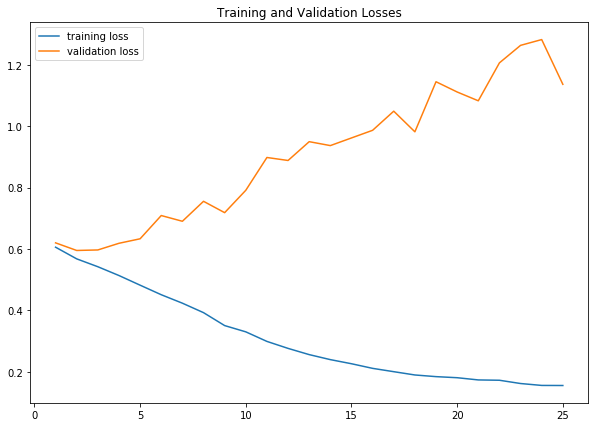

In [59]:
plot_history(history)

## Randomized Search for optimal hyper-parameters

In [ ]:
from hyperopt import hp

# hyper parameter search space'
space = {
    'lr': hp.loguniform('lr', np.log(1e-4), np.log(3e-2)),
    'n_layers': hp.choice("n_layers", range(2, 4, 1)),
    'dropout': hp.uniform("dropouut", 0.25, 0.5),
    'b1': hp.loguniform('b1', np.log(0.5), np.loh(0.9)),
    'b2': hp.loguniform('b2', np.log(0.5), np.loh(0.999)),
    'weight_decay': hp.loguniform('weight_decay', np.log(0.01), np.log(1))
}

